# Good Film // Bad Film
## Predicting IMdB Critic Scores with Pre-Release Movie Metadata

This notebook builds and evaluates a handful of regression models which predict critical reception scores for films. Independent variables include plot synopsis free text, social media metrics on the leading actors, and other categorical variables such as film genre.

In [3]:
# Data Wrangling
import pandas as pd
import numpy as np
from scipy.stats import boxcox

# Viz
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="white")

# Python Extras
import os
import time
import pickle
from unicodedata import normalize

# API Calls and Parsing
import requests
from pycountry import languages

# NLP Tools
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Model Prep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# SKLearn Models and Tools
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LassoCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

***

# Data Collection

## Kaggle Dataset

From https://www.kaggle.com/tmdb/tmdb-movie-metadata:

In [4]:
kaggle_data = pd.read_csv('../data/imdb_5000_movies.csv') # Just a big Kaggle dataset full of movies.

In [5]:
kaggle_data.shape

(5043, 28)

## Extra Metadata from TheMovieDB.org

One good thing about this dataset is that it provides the unique IMdB movie ID's, which we can pass to a third-party API in order to supplement our data with more features. Here we parse out those IMdB ID's:

In [6]:
kaggle_data.tail()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
5038,Color,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,...,6.0,English,Canada,NaN,NaN,2013.0,470.0,7.7,NaN,84
5039,Color,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,...,359.0,English,USA,TV-14,NaN,NaN,593.0,7.5,16.00,32000
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
5041,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,9.0,English,USA,PG-13,NaN,2012.0,719.0,6.3,2.35,660
5042,Color,Jon Gunn,43.0,90.0,16.0,16.0,Brian Herzlinger,86.0,85222.0,Documentary,...,84.0,English,USA,PG,1100.0,2004.0,23.0,6.6,1.85,456


Grab IMdB ID numbers for each film and append to dataframe:

In [7]:
imdb_ids = kaggle_data['movie_imdb_link'].str[26:35]
# imdb_ids[3000:3005]

In [8]:
kaggle_data['imdb_ids'] = imdb_ids

Here we make the API calls, and persist our data to little .json files:

In [9]:
try:
    os.mkdir('../data/movie_metadata')
except FileExistsError:
    pass

__This will make lots of API calls, be warned and use sparingly__, to avoid burning out your API key

You will need to enter your own API key in the API_KEY.py file (remove the .template suffix)

In [10]:
# from API_KEY import API_KEY
# i=0; j=0; total=len(imdb_ids)

# for id in imdb_ids:
#     print(f"Downloading movie {i} of {total}...")
#     i+=1
#     query_string = f'https://api.themoviedb.org/3/movie/{id}?api_key={API_KEY}'
#     json = requests.get(query_string).text
#     if "could not be found" in json:
#         j+=1
#         print(f"{round(j/i, 2)}% of movies not found")
#         continue
#     f = open(f'../data/movie_metadata/movie_{id}.json', 'w+')
#     f.write(json)
#     f.close()

## Combine Kaggle Dataset and TheMovieDB API Responses

In [11]:
tmdb_movies = pd.DataFrame()

for filename in os.listdir(path='../data/movie_metadata/'):
    if "movie" in filename:
        this_movie = pd.read_json(f"../data/movie_metadata/{filename}", lines=True)
        tmdb_movies = pd.concat([this_movie,tmdb_movies], axis=0)

tmdb_movies = tmdb_movies.reset_index(drop=True)

In [12]:
df_merged = tmdb_movies.merge(kaggle_data, 
                              how='left',
                              left_on='imdb_id',
                              right_on='imdb_ids',
                              suffixes=("_kaggle","_api"))

In [13]:
df_merged.head()

(4925, 54)

***

# Data Cleaning and EDA

## Keep only interesting columns

In [14]:
df_merged.columns

Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget_kaggle',
       'genres_kaggle', 'homepage', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'color', 'director_name',
       'num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes',
       'gross', 'genres_api', 'actor_1_name', 'movie_title', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
       'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language',
       'country', 'content_rating', 'budget_api', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes', 'imdb_ids'],
      dtyp

In [15]:
desired_cols = ("imdb_id duration adult budget_api budget_kaggle language original_language "
                "production_countries runtime spoken_languages color genres_api "
                "title movie_title original_title overview content_rating "
                "actor_1_facebook_likes actor_2_facebook_likes actor_3_facebook_likes "
                "director_facebook_likes cast_total_facebook_likes facenumber_in_poster "
                "aspect_ratio imdb_score revenue").split()

In [16]:
df_lesscols = df_merged[desired_cols]
df_lesscols.head()

,imdb_id,duration,adult,budget_api,budget_kaggle,language,original_language,production_countries,runtime,spoken_languages,...,content_rating,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,aspect_ratio,imdb_score,revenue
0,tt5215952,156.0,False,NaN,10951000,Korean,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",...,Not Rated,45.0,5.0,0.0,43.0,50,0.0,2.35,7.7,47098491
1,tt5078326,102.0,False,NaN,0,French,fr,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",...,NaN,541.0,8.0,2.0,12.0,553,2.0,NaN,7.2,0
2,tt5001130,100.0,False,3500000.0,3500000,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,NaN,21.0,3.0,0.0,117.0,24,0.0,NaN,7.0,0
3,tt4939066,115.0,False,12620000.0,12700000,English,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",111.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",...,NaN,14000.0,81.0,29.0,32.0,14133,1.0,NaN,6.8,49196532
4,tt4871980,96.0,False,5000000.0,0,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,R,927.0,509.0,503.0,23.0,3552,6.0,NaN,4.5,0


## Drop Duplicate Rows

In [17]:
df_lesscols[
    df_lesscols.imdb_id.duplicated(keep=False)
].sort_values('imdb_id')[
    "imdb_id duration title language".split()
].head(51)

,imdb_id,duration,title,language
4865,tt0046672,127.0,"20,000 Leagues Under the Sea",English
4864,tt0046672,127.0,"20,000 Leagues Under the Sea",English
4837,tt0056193,152.0,Lolita,English
4838,tt0056193,152.0,Lolita,English
4792,tt0063350,96.0,Night of the Living Dead,English
4793,tt0063350,96.0,Night of the Living Dead,English
4758,tt0067116,104.0,The French Connection,English
4759,tt0067116,104.0,The French Connection,English
4728,tt0072271,88.0,The Texas Chain Saw Massacre,English
4727,tt0072271,88.0,The Texas Chain Saw Massacre,English


In [18]:
df_lesscols[
    df_lesscols.imdb_id.duplicated(keep=False)
].sort_values('imdb_id')[
    "imdb_id duration title language".split()
].tail(50)

,imdb_id,duration,title,language
962,tt1528100,150.0,Exodus: Gods and Kings,English
961,tt1528100,150.0,Exodus: Gods and Kings,English
853,tt1623205,130.0,Oz the Great and Powerful,English
852,tt1623205,130.0,Oz the Great and Powerful,English
805,tt1661199,105.0,Cinderella,English
804,tt1661199,105.0,Cinderella,English
795,tt1666335,108.0,The Calling,English
796,tt1666335,108.0,The Calling,English
787,tt1673434,115.0,The Twilight Saga: Breaking Dawn - Part 2,English
786,tt1673434,115.0,The Twilight Saga: Breaking Dawn - Part 2,English


In [19]:
df_lesscols = df_lesscols.drop_duplicates(subset='imdb_id').set_index("imdb_id")

In [20]:
df_lesscols.head(3)

,duration,adult,budget_api,budget_kaggle,language,original_language,production_countries,runtime,spoken_languages,color,...,content_rating,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,aspect_ratio,imdb_score,revenue
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,156.0,False,NaN,10951000,Korean,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Color,...,Not Rated,45.0,5.0,0.0,43.0,50,0.0,2.35,7.7,47098491
tt5078326,102.0,False,NaN,0,French,fr,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Color,...,NaN,541.0,8.0,2.0,12.0,553,2.0,NaN,7.2,0
tt5001130,100.0,False,3500000.0,3500000,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Color,...,NaN,21.0,3.0,0.0,117.0,24,0.0,NaN,7.0,0


## Null Values Management

Here are all of the truly "null" values:

[]

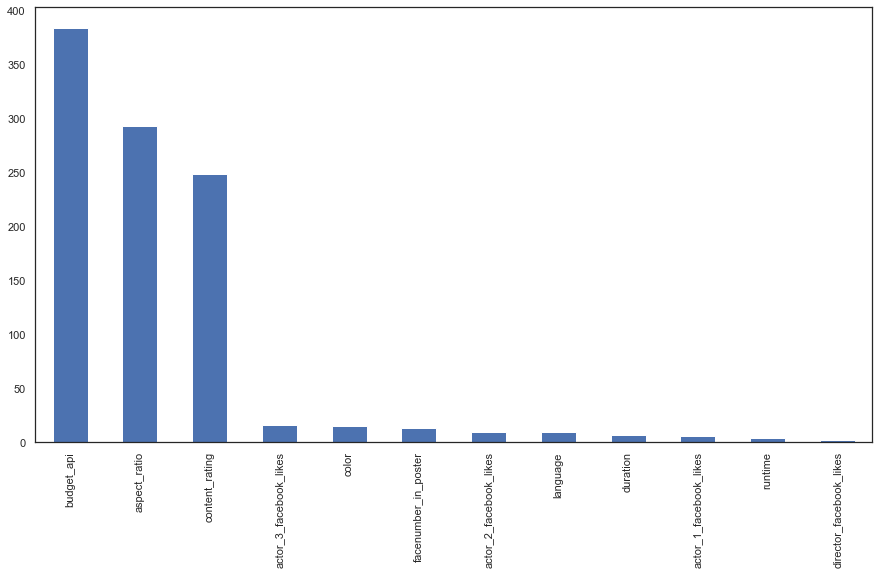

In [21]:
nulls = df_lesscols.isna().sum()[df_lesscols.isna().sum() > 0].sort_values(ascending=False)

nulls.plot(kind='bar', figsize=(15,8)).plot()

Gotta start somewhere.

### Budget

We have two disparate budget columns to draw from. We want whatever seems most plausible.

In [22]:
df_lesscols[["budget_api", "budget_kaggle"]].head(10)

,budget_api,budget_kaggle
imdb_id,,
tt5215952,NaN,10951000
tt5078326,NaN,0
tt5001130,3500000.0,3500000
tt4939066,12620000.0,12700000
tt4871980,5000000.0,0
tt4824308,5000000.0,5000000
tt4786282,4900000.0,4900000
tt4733536,990000.0,0
tt4707756,168000.0,0


Lots of nulls in budget_api, lots of zeroes in budget_kaggle. How best to handle this? And are there other columns where we just have a bunch of zero values instead of nulls (revenue??)

In [23]:
def best_guess_budget(row):
    # When budget_api is NaN and budget_kaggle is non-zero, take budget_kaggle.
    if row.isna()["budget_api"] and row['budget_kaggle'] != 0:
        return row['budget_kaggle']
    
    # When budget_api is not NaN but budget_kaggle is zero, take budget_api.
    elif not row.isna()["budget_api"] and row['budget_kaggle'] == 0:
        return row['budget_api']
    
    # When both values are not NaN / non-zero, take the mean?
    elif not row.isna()["budget_api"] and row['budget_kaggle'] != 0:
        return np.mean((row['budget_kaggle'], row['budget_api']))
        
    # When budget_api is NaN AND budget_kaggle is zero...that's tough. Maybe drop row. Consider imputing values?
    else:
        return None

In [24]:
df_lesscols.head(10).apply(best_guess_budget, axis=1)

imdb_id
tt5215952    10951000.0
tt5078326           NaN
tt5001130     3500000.0
tt4939066    12660000.0
tt4871980     5000000.0
tt4824308     5000000.0
tt4786282     4900000.0
tt4733536      990000.0
tt4707756      168000.0
tt4704314     2000000.0
dtype: float64

This is the desired behavior.

In [25]:
best_budget = df_lesscols.apply(best_guess_budget, axis=1)

In [26]:
df_best_guess_budget = df_lesscols.assign(best_budget=best_budget
                                         ).drop("budget_api budget_kaggle".split(), axis=1)

In [27]:
df_best_guess_budget.best_budget.isna().mean()

0.05579845929627316

5% of budget values are missing. I think I will in fact impute the median.

In [28]:
budget_med = df_best_guess_budget.best_budget.dropna().median()
budget_mean = df_best_guess_budget.best_budget.dropna().mean()
budget_med, budget_mean

(19000000.0, 36654712.14840132)

In [29]:
df_filled_budget = df_best_guess_budget.assign(
    filled_budget = df_best_guess_budget["best_budget"].fillna(budget_med)
).drop(["best_budget"],axis=1)

In [30]:
df_filled_budget.filled_budget.isna().mean()

0.0

In [31]:
df_filled_budget.filled_budget.median(), df_filled_budget.filled_budget.mean()

(19000000.0, 35669606.411201335)

This doesn't seem to have shifted the mean much, that's good.

### Aspect Ratio

In [32]:
df_filled_budget.aspect_ratio.isna().mean()

0.0610035394545076

6% of aspect ratios are null.

This is a categorical describing the dimensions of the projected image. Your TV set is 16x9 aka 1.77 aspect ratio, whereas lots of hollywood films are 1.85 ratio or 2.40, much "wider-screen". 2.40 might be "artsier".

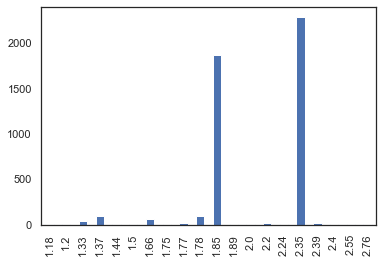

In [33]:
# Aspect ratio of 16 I take to mean 16x9 aka 1.77:
df_filled_budget.aspect_ratio = df_filled_budget.aspect_ratio.apply(lambda x: 1.77 if x==16 else x)
df_filled_budget.aspect_ratio.value_counts().sort_index().plot(kind="bar")

I think I will lump some of these together and impute 1.85 on null values. It's not *quite* the mode but it's a sort of middle-of-the road aspect ratio. The DCI standard lists 2.39 and 1.85 for theatrical projection. 16x9 or 1.77 is also common, and 4/3 or 1.33 is like an old-timey boxey aspect ratio.

In [34]:
aspect_bins = [0, np.mean((1.33, 1.77)), np.mean((1.77,1.85)), np.mean((1.85,2.39)), np.inf]
aspect_labels = "1.33 1.77 1.85 2.39".split()

In [35]:
pd.cut(df_filled_budget.aspect_ratio, 
       bins=aspect_bins, 
       labels=aspect_labels,
       include_lowest=True)

imdb_id
tt5215952    2.39
tt5078326     NaN
tt5001130     NaN
tt4939066     NaN
tt4871980     NaN
             ... 
tt0018737    1.33
tt0017136    1.33
tt0015624    1.33
tt0011549    1.33
tt0006864    1.33
Name: aspect_ratio, Length: 4803, dtype: category
Categories (4, object): [1.33 < 1.77 < 1.85 < 2.39]

Lump values and impute 1.85:

In [36]:
df_fixed_aspect = df_filled_budget.assign(fixed_aspect = pd.cut(df_filled_budget.aspect_ratio, 
                                                         bins=aspect_bins, 
                                                         labels=aspect_labels,
                                                         include_lowest=True
                                                               ).fillna("1.85")
                                         ).drop(["aspect_ratio"],axis=1)

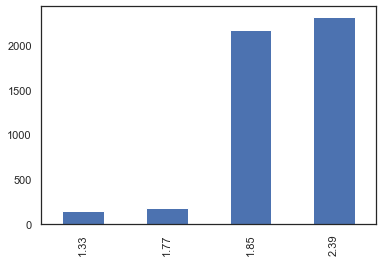

In [37]:
df_fixed_aspect.fixed_aspect.value_counts().sort_index().plot(kind="bar")

### Content Rating

In [38]:
df_fixed_aspect.content_rating.isna().mean()

0.051842598376014994

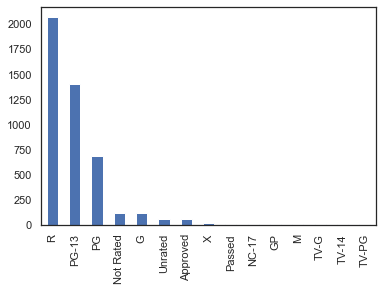

In [39]:
df_fixed_aspect.content_rating.value_counts().plot(kind="bar")

Just gonna fill nulls with PG-13 and condense redundant ones

In [40]:
df_content_rating_filled = df_fixed_aspect.assign(
                                content_rating=df_fixed_aspect.content_rating.fillna("PG-13")
                           )

In [41]:
def rating_mapper(rating):
    if rating == "Not Rated":
        return "Unrated"
    elif rating in "Approved Passed M TV-14".split():
        return "PG-13"
    elif rating in "TV-G GP G TV-PG".split():
        return "PG"
    elif rating in ["NC-17"]:
        return "X"
    else:
        return rating

In [42]:
df_content_rating_condensed = df_content_rating_filled.assign(
                                content_rating = df_content_rating_filled.content_rating.map(rating_mapper)
                              )

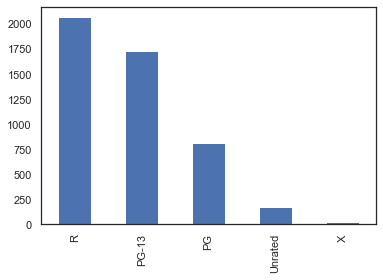

In [43]:
df_content_rating_condensed.content_rating.value_counts().plot(kind="bar")

In [44]:
df_content_rating_condensed.content_rating.isna().mean()

0.0

How are we doing on null values globally?

[]

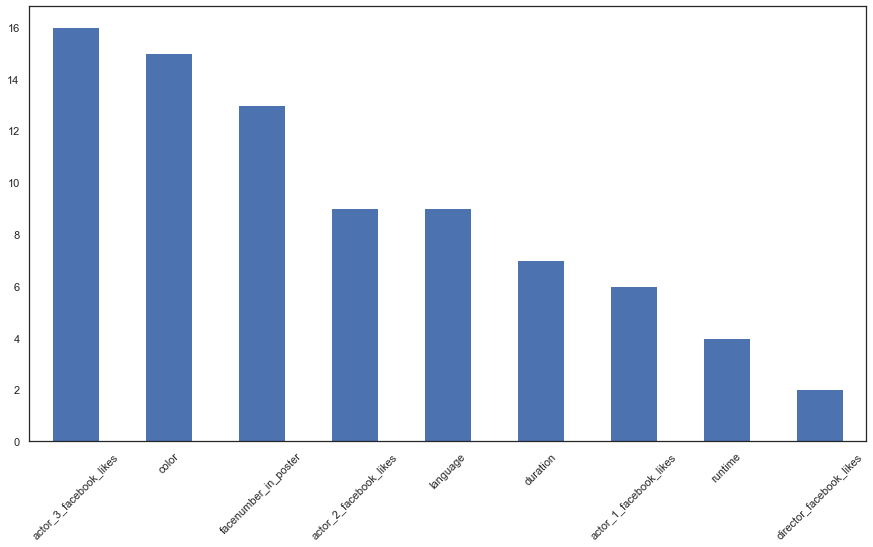

In [45]:
nulls_update = df_content_rating_condensed.isna().sum()[
    df_content_rating_condensed.isna().sum() > 0
].sort_values(ascending=False)

nulls_update.plot(kind='bar', figsize=(15,8), rot=45).plot()

Clearing some memory:

In [46]:
del nulls
del imdb_ids
del kaggle_data
del best_budget
del df_lesscols
del df_best_guess_budget
del df_filled_budget
del df_content_rating_filled
del df_fixed_aspect

### Facebook Like Counts

In [47]:
facebook_like_cols = [col for col in df_content_rating_condensed if "facebook" in col]
likes = df_content_rating_condensed[facebook_like_cols]

df_content_rating_condensed.drop(facebook_like_cols, axis=1, inplace=True)

likes.head()

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
imdb_id,,,,,
tt5215952,45.0,5.0,0.0,43.0,50
tt5078326,541.0,8.0,2.0,12.0,553
tt5001130,21.0,3.0,0.0,117.0,24
tt4939066,14000.0,81.0,29.0,32.0,14133
tt4871980,927.0,509.0,503.0,23.0,3552


In [48]:
(round(likes.isna().mean()*100,2)).sort_values(ascending=False).astype('str')+"%"

actor_3_facebook_likes       0.33%
actor_2_facebook_likes       0.19%
actor_1_facebook_likes       0.12%
director_facebook_likes      0.04%
cast_total_facebook_likes     0.0%
dtype: object

Not that many values are missing. Will just use the medians.

In [49]:
likes.fillna({col:likes[col].median() for col in likes.columns}, inplace=True)

/Users/admin/.local/share/virtualenvs/Good-Film-Bad-Film-vaMlpeB4/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [50]:
df_likes_filled = pd.concat([df_content_rating_condensed,
                             likes], axis=1)

In [51]:
del df_content_rating_condensed
del likes

Time for another check-in:

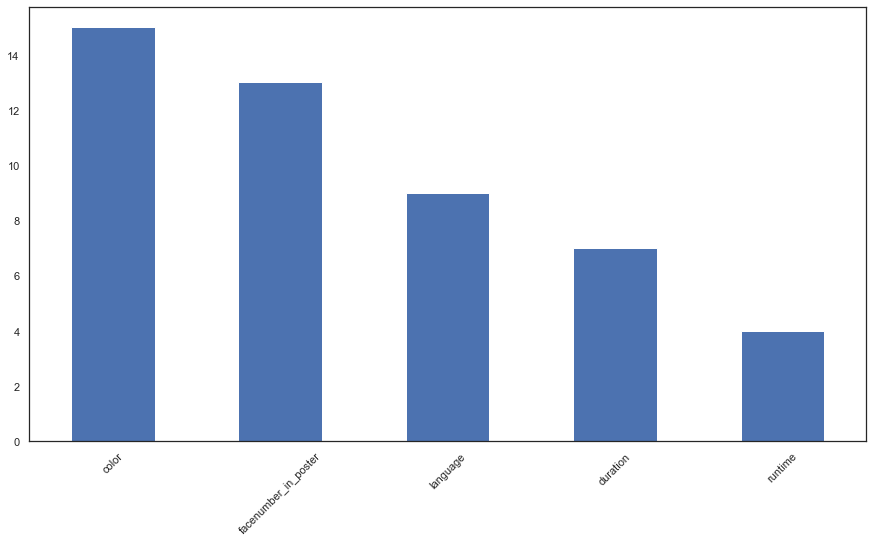

In [52]:
nulls_update = df_likes_filled.isna().sum()[
    df_likes_filled.isna().sum() > 0
].sort_values(ascending=False)

nulls_update.plot(kind='bar', figsize=(15,8), rot=45).plot()

del nulls_update

### Color

In [53]:
df_likes_filled.color = df_likes_filled.color.str.lstrip()
df_likes_filled.color.value_counts()

Color              4587
Black and White     201
Name: color, dtype: int64

Seems safe to assume that the last dozen films are in color...

In [54]:
df_likes_filled.color = df_likes_filled.color.fillna(df_likes_filled.color.mode()[0])
df_color_filled = df_likes_filled.copy()

In [55]:
del df_likes_filled

In [56]:
df_color_filled.head(3)

,duration,adult,language,original_language,production_countries,runtime,spoken_languages,color,genres_api,title,...,facenumber_in_poster,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,156.0,False,Korean,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Color,Fantasy|Horror|Mystery|Thriller,The Wailing,...,0.0,7.7,47098491,10951000.0,2.39,45.0,5.0,0.0,43.0,50
tt5078326,102.0,False,French,fr,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Color,Comedy|Drama,The Country Doctor,...,2.0,7.2,0,19000000.0,1.85,541.0,8.0,2.0,12.0,553
tt5001130,100.0,False,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Color,Documentary,Time to Choose,...,0.0,7.0,0,3500000.0,1.85,21.0,3.0,0.0,117.0,24


In [57]:
df_color_filled.color.isna().mean()

0.0

### Face Number in Poster

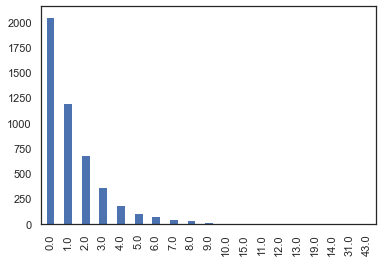

In [58]:
df_color_filled.facenumber_in_poster.value_counts().plot(kind='bar')

Zero seems to be a placeholder for "idk" in this dataset, I'll drop this column.

In [59]:
df_no_facenums = df_color_filled.drop(['facenumber_in_poster'],axis=1)
del df_color_filled
df_no_facenums.head()

,duration,adult,language,original_language,production_countries,runtime,spoken_languages,color,genres_api,title,...,content_rating,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,156.0,False,Korean,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Color,Fantasy|Horror|Mystery|Thriller,The Wailing,...,Unrated,7.7,47098491,10951000.0,2.39,45.0,5.0,0.0,43.0,50
tt5078326,102.0,False,French,fr,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Color,Comedy|Drama,The Country Doctor,...,PG-13,7.2,0,19000000.0,1.85,541.0,8.0,2.0,12.0,553
tt5001130,100.0,False,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Color,Documentary,Time to Choose,...,PG-13,7.0,0,3500000.0,1.85,21.0,3.0,0.0,117.0,24
tt4939066,115.0,False,English,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",111.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Color,Action|Drama|History|War,Operation Chromite,...,PG-13,6.8,49196532,12660000.0,1.85,14000.0,81.0,29.0,32.0,14133
tt4871980,96.0,False,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Color,Comedy|Romance,The Perfect Match,...,R,4.5,0,5000000.0,1.85,927.0,509.0,503.0,23.0,3552


### Language ("original... spoken... language")

In [60]:
langs = df_no_facenums[[col for col in df_no_facenums.columns if "language" in col]]
langs.head(15)

,language,original_language,spoken_languages
imdb_id,,,
tt5215952,Korean,ko,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso..."
tt5078326,French,fr,"[{'iso_639_1': 'fr', 'name': 'Français'}]"
tt5001130,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
tt4939066,English,ko,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso..."
tt4871980,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
tt4824308,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
tt4786282,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
tt4733536,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
tt4707756,Romanian,ro,"[{'iso_639_1': 'ro', 'name': 'Română'}]"


In [61]:
langs.isna().mean()

language             0.001874
original_language    0.000000
spoken_languages     0.000000
dtype: float64

In [62]:
df_no_facenums.iloc[13,:]

duration                                                                   NaN
adult                                                                    False
language                                                                  Urdu
original_language                                                           ur
production_countries                [{'iso_3166_1': 'PK', 'name': 'Pakistan'}]
runtime                                                                    144
spoken_languages                         [{'iso_639_1': 'ur', 'name': 'اردو'}]
color                                                                    Color
genres_api                                                       Comedy|Family
title                                                        Karachi Se Lahore
movie_title                                                 Karachi se Lahore 
original_title                                                  کراچی سے لاہور
overview                     A road trip from Karach

The "language" column looks not great. "original language" is probably a better bet.

In [63]:
df_no_facenums.spoken_languages.tail()

imdb_id
tt0018737    [{'iso_639_1': 'xx', 'name': 'No Language'}]
tt0017136    [{'iso_639_1': 'xx', 'name': 'No Language'}]
tt0015624    [{'iso_639_1': 'xx', 'name': 'No Language'}]
tt0011549    [{'iso_639_1': 'xx', 'name': 'No Language'}]
tt0006864    [{'iso_639_1': 'xx', 'name': 'No Language'}]
Name: spoken_languages, dtype: object

In [64]:
df_no_facenums.original_language.tail()

imdb_id
tt0018737    de
tt0017136    de
tt0015624    en
tt0011549    en
tt0006864    en
Name: original_language, dtype: object

Yeah I think that's probably the best column.

In [65]:
df_no_facenums.original_language.value_counts().head(10)

en    4483
fr      74
es      34
hi      29
zh      27
de      27
ja      16
cn      14
ko      12
it      11
Name: original_language, dtype: int64

Using a python package to make language codes human-readable:

In [66]:
lang_decoder = {lang.alpha_2: lang.name for lang in languages if hasattr(lang,'alpha_2')}
list(lang_decoder.items())[:5]

[('aa', 'Afar'),
 ('ab', 'Abkhazian'),
 ('af', 'Afrikaans'),
 ('ak', 'Akan'),
 ('am', 'Amharic')]

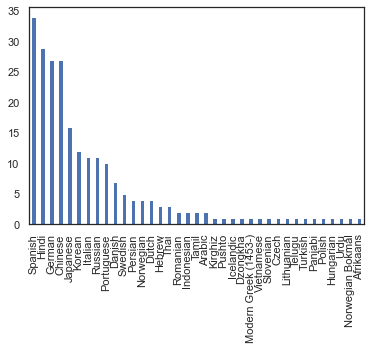

In [67]:
df_no_facenums.original_language = df_no_facenums.original_language.map(lang_decoder)
df_no_facenums.original_language.value_counts()[2:].plot(kind='bar')

Just eyeballing it...I think anything after German, in terms of frequency, is gonna have to go in "other"

Grabbing most popular languages:

In [68]:
top_langs = df_no_facenums.original_language.value_counts().index[:3].tolist()
top_langs

['English', 'French', 'Spanish']

In [69]:
def language_lumper(lang):
    if lang not in top_langs:
        return "Other"
    else:
        return lang

In [70]:
df_no_facenums.original_language = df_no_facenums.original_language.apply(language_lumper)

In [71]:
df_langs_lumped = df_no_facenums.drop("language spoken_languages".split(),axis=1)
del df_no_facenums
del langs

In [72]:
df_langs_lumped.head()

,duration,adult,original_language,production_countries,runtime,color,genres_api,title,movie_title,original_title,...,content_rating,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,156.0,False,Other,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,Color,Fantasy|Horror|Mystery|Thriller,The Wailing,The Wailing,곡성,...,Unrated,7.7,47098491,10951000.0,2.39,45.0,5.0,0.0,43.0,50
tt5078326,102.0,False,French,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,Color,Comedy|Drama,The Country Doctor,Irreplaceable,Médecin de campagne,...,PG-13,7.2,0,19000000.0,1.85,541.0,8.0,2.0,12.0,553
tt5001130,100.0,False,English,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,Color,Documentary,Time to Choose,Time to Choose,Time to Choose,...,PG-13,7.0,0,3500000.0,1.85,21.0,3.0,0.0,117.0,24
tt4939066,115.0,False,Other,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",111.0,Color,Action|Drama|History|War,Operation Chromite,Operation Chromite,인천상륙작전,...,PG-13,6.8,49196532,12660000.0,1.85,14000.0,81.0,29.0,32.0,14133
tt4871980,96.0,False,English,"[{'iso_3166_1': 'US', 'name': 'United States o...",96.0,Color,Comedy|Romance,The Perfect Match,The Perfect Match,The Perfect Match,...,R,4.5,0,5000000.0,1.85,927.0,509.0,503.0,23.0,3552


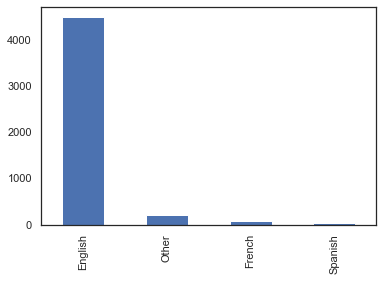

In [73]:
df_langs_lumped.original_language.value_counts().plot(kind='bar')

***

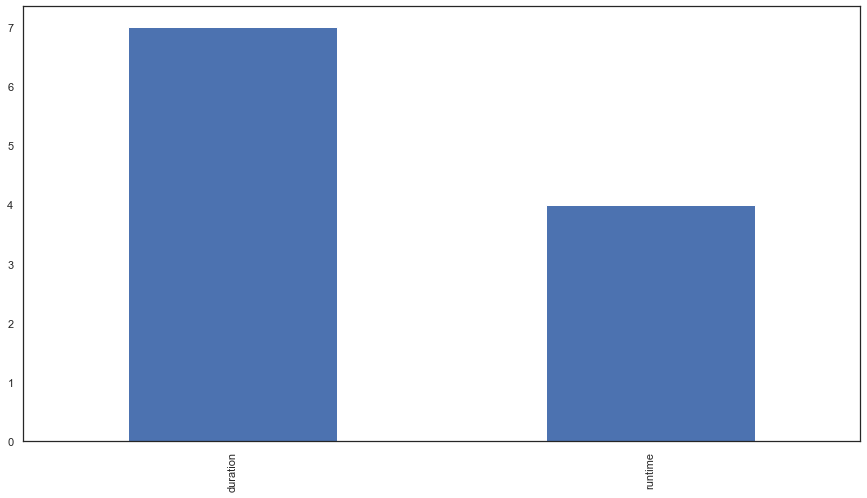

In [74]:
nulls = df_langs_lumped.isna().sum()[df_langs_lumped.isna().sum() > 0].sort_values(ascending=False)

nulls.plot(kind='bar', figsize=(15,8)).plot()

del nulls

### Duration / Runtime

In [75]:
durs = df_langs_lumped["duration runtime".split()]
durs.head()

,duration,runtime
imdb_id,,
tt5215952,156.0,156.0
tt5078326,102.0,102.0
tt5001130,100.0,100.0
tt4939066,115.0,111.0
tt4871980,96.0,96.0


How different are these columns?

0.9607679465776294

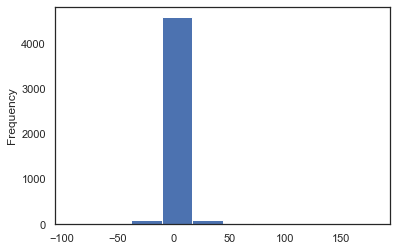

In [76]:
(durs.duration - durs.runtime).plot(kind='hist')
(durs.duration - durs.runtime).mean()

Not very.

In [77]:
df_langs_lumped.drop(["duration"],axis=1,inplace=True)

In [78]:
df_runtimes_filled = df_langs_lumped.assign(
    durations=df_langs_lumped.runtime.fillna(
        df_langs_lumped.runtime.median()
    )
).drop(["runtime"],axis=1)

del df_langs_lumped
del durs

In [79]:
df_runtimes_filled.isna().mean()

adult                        0.0
original_language            0.0
production_countries         0.0
color                        0.0
genres_api                   0.0
title                        0.0
movie_title                  0.0
original_title               0.0
overview                     0.0
content_rating               0.0
imdb_score                   0.0
revenue                      0.0
filled_budget                0.0
fixed_aspect                 0.0
actor_1_facebook_likes       0.0
actor_2_facebook_likes       0.0
actor_3_facebook_likes       0.0
director_facebook_likes      0.0
cast_total_facebook_likes    0.0
durations                    0.0
dtype: float64

**No more obvious nulls!**

In [80]:
df_runtimes_filled.to_pickle("../data/pickles/df_no_nulls.pkl")

## Categorical Columns

In [81]:
df_no_nulls = pd.read_pickle("../data/pickles/df_no_nulls.pkl")
df_no_nulls.columns.tolist()

['adult',
 'original_language',
 'production_countries',
 'color',
 'genres_api',
 'title',
 'movie_title',
 'original_title',
 'overview',
 'content_rating',
 'imdb_score',
 'revenue',
 'filled_budget',
 'fixed_aspect',
 'actor_1_facebook_likes',
 'actor_2_facebook_likes',
 'actor_3_facebook_likes',
 'director_facebook_likes',
 'cast_total_facebook_likes',
 'durations']

### "Adult"

In [82]:
df_no_nulls.adult.value_counts()

False    4803
Name: adult, dtype: int64

Single-value column. Drop it

In [83]:
df_no_adult = df_no_nulls.drop(["adult"],axis=1)
del df_no_nulls

In [84]:
df_no_adult.columns

Index(['original_language', 'production_countries', 'color', 'genres_api',
       'title', 'movie_title', 'original_title', 'overview', 'content_rating',
       'imdb_score', 'revenue', 'filled_budget', 'fixed_aspect',
       'actor_1_facebook_likes', 'actor_2_facebook_likes',
       'actor_3_facebook_likes', 'director_facebook_likes',
       'cast_total_facebook_likes', 'durations'],
      dtype='object')

### Production Countries

In [85]:
df_no_adult['production_countries'].head()

imdb_id
tt5215952        [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
tt5078326             [{'iso_3166_1': 'FR', 'name': 'France'}]
tt5001130    [{'iso_3166_1': 'US', 'name': 'United States o...
tt4939066        [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
tt4871980    [{'iso_3166_1': 'US', 'name': 'United States o...
Name: production_countries, dtype: object

Hmm list of dict. Let's just grab the human-readable names:

In [86]:
def prod_countries_extractor(countries):
    if len(countries)!=0:
        return {country['name'] for country in countries}
    else:
        return {}

In [87]:
df_no_adult.production_countries = df_no_adult.production_countries.apply(prod_countries_extractor)

In [88]:
df_no_adult.production_countries.iloc[29:34]

imdb_id
tt4280822                    {United States of America}
tt4273494                                            {}
tt4263482    {United States of America, United Kingdom}
tt4262980                                       {Japan}
tt4257926                    {United States of America}
Name: production_countries, dtype: object

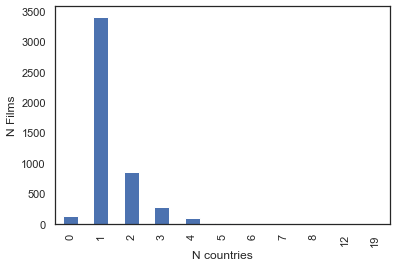

In [89]:
# Turns out pandas vectorized string operations work on lists too
ax = df_no_adult.production_countries.str.len().value_counts().sort_index().plot(kind='bar')
ax.set_xlabel("N countries")
ax.set_ylabel("N Films")
ax.plot()
del ax

I feel like that ^ can become an int column, after the zeroes are fixed

In [90]:
# If it's not in English, can we guess where it was filmed?
df_no_adult[(
                df_no_adult.production_countries.str.len()==0
            )&(
                df_no_adult.original_language!="English"
            )]

,original_language,production_countries,color,genres_api,title,movie_title,original_title,overview,content_rating,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes,durations
imdb_id,,,,,,,,,,,,,,,,,,,
tt2141739,Other,{},Color,Documentary|News,Food Chains,Food Chains,Food Chains,,PG-13,7.1,0,913000.0,1.85,56.0,28.0,17.0,0.0,104,83.0
tt0473553,Other,{},Color,Horror|Thriller,The Tooth Fairy,The Tooth Fairy,The Tooth Fairy,A woman and her daughter (Nicole Muñoz) encoun...,PG-13,4.6,0,1500000.0,1.77,598.0,555.0,235.0,42.0,2353,89.0
tt0432637,Other,{},Color,Action|Adventure|Romance|Sci-Fi,Krrish,Krrish,कृष,"In Singapore, Krishna is forced by circumstanc...",Unrated,6.3,0,10000000.0,2.39,307.0,200.0,45.0,53.0,616,174.0
tt0249588,Other,{},Color,Action|Comedy|Romance|Thriller,Hum To Mohabbat Karega,Hum To Mohabbat Karega,Hum To Mohabbat Karega,A man lies about being an eyewitness to a murd...,PG-13,2.8,0,19000000.0,1.85,353.0,89.0,72.0,4.0,613,148.0


In [91]:
guesses = {480:"Germany", 
           2051:"Germany",
           2260:"India",
           3242:"India"}

for index, country in guesses.items():
    df_no_adult['production_countries'].iloc[index] = country
    
del index
del country

/Users/admin/.local/share/virtualenvs/Good-Film-Bad-Film-vaMlpeB4/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [92]:
pd.DataFrame([df_no_adult.iloc[i,:] for i in guesses.keys()])

,original_language,production_countries,color,genres_api,title,movie_title,original_title,overview,content_rating,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes,durations
tt2111292,English,Germany,Color,Action,Diamond Ruff,Diamond Ruff,Diamond Ruff,"Action - Orphan, con artist, crime boss and mi...",R,4.3,0,500000.0,1.85,472.0,251.0,237.0,5.0,1752,0.0
tt0462395,English,Germany,Color,Comedy|Romance,Larry the Cable Guy: Health Inspector,Larry the Cable Guy: Health Inspector,Larry the Cable Guy: Health Inspector,A slovenly cable repairman becomes a big-city ...,PG-13,3.1,0,4000000.0,1.33,690.0,400.0,323.0,0.0,2135,89.0
tt0421237,English,India,Color,Action|Thriller,Royal Kill,Royal Kill,Royal Kill,A fearsome warrior from the Kingdom of Samarza...,PG-13,3.2,0,350000.0,1.85,502.0,119.0,32.0,0.0,689,90.0
tt0229260,English,India,Color,Adventure|Fantasy|Horror|Mystery|Thriller,Book of Shadows: Blair Witch 2,Book of Shadows: Blair Witch 2,Book of Shadows: Blair Witch 2,Young adults become fascinated by the events o...,R,4.0,0,15000000.0,1.85,193.0,184.0,162.0,31.0,608,90.0


In [93]:
del guesses

In [94]:
df_no_adult.production_countries.value_counts().head(10)

TypeError: unhashable type: 'set'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'set'


{United States of America}                    2990
{United States of America, United Kingdom}     210
{}                                             136
{United States of America, Germany}            134
{United Kingdom}                               127
{Canada, United States of America}             103
{United States of America, Australia}           55
{France}                                        49
{Canada}                                        45
{United States of America, France}              43
Name: production_countries, dtype: int64

In [95]:
def fill_with_USA(country_set):
    return {"United States of America"} if country_set == {} else country_set

In [96]:
df_no_adult["production_countries"] = df_no_adult.production_countries.apply(fill_with_USA)

In [97]:
df_filled_USA = df_no_adult.copy()
del df_no_adult

Might need to split into USA and not-USA to deal with class imbalance

In [98]:
def usa_or_not(country_set):
    return 0 if country_set=={"United States of America"} else 1

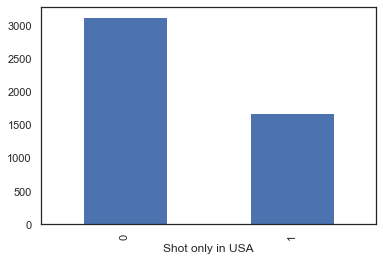

In [99]:
ax = df_filled_USA.production_countries.apply(usa_or_not).value_counts().plot(kind='bar')
ax.set_xlabel("Shot only in USA")
del ax

In [100]:
df_filled_USA['shot_only_in_USA'] = df_filled_USA.production_countries.apply(usa_or_not)

In [101]:
def shot_in_usa_and_abroad(country_set):
    if len(country_set)>1 and "United States of America" in country_set:
        return 1
    else:
        return 0

In [102]:
df_filled_USA['shot_in_USA_and_abroad'] = df_filled_USA.production_countries.apply(shot_in_usa_and_abroad)

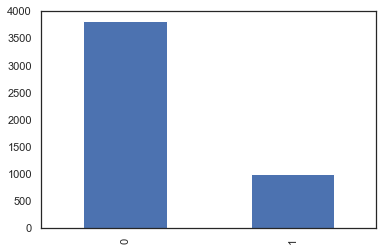

In [103]:
df_filled_USA['shot_in_USA_and_abroad'].value_counts().plot(kind='bar')

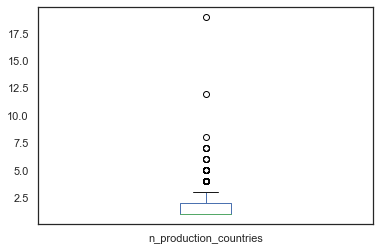

In [104]:
df_filled_USA['n_production_countries'] = df_filled_USA.production_countries.str.len()
df_filled_USA['n_production_countries'].plot(kind='box')

In [105]:
df_n_countries = df_filled_USA.drop(["production_countries"],axis=1)

In [106]:
del df_filled_USA

In [107]:
df_n_countries.columns.tolist()

['original_language',
 'color',
 'genres_api',
 'title',
 'movie_title',
 'original_title',
 'overview',
 'content_rating',
 'imdb_score',
 'revenue',
 'filled_budget',
 'fixed_aspect',
 'actor_1_facebook_likes',
 'actor_2_facebook_likes',
 'actor_3_facebook_likes',
 'director_facebook_likes',
 'cast_total_facebook_likes',
 'durations',
 'shot_only_in_USA',
 'shot_in_USA_and_abroad',
 'n_production_countries']

### Genre

In [108]:
df_n_countries['genre'] = df_n_countries['genres_api'].str.split("|")
df_n_countries['genre'] = df_n_countries['genre'].apply(lambda x: set(x))
del df_n_countries["genres_api"]

In [109]:
df_n_countries['genre'].apply(lambda x: set(x)).value_counts().head(20)

TypeError: unhashable type: 'set'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'set'


{Drama}                              230
{Comedy}                             196
{Comedy, Drama}                      187
{Comedy, Romance, Drama}             182
{Comedy, Romance}                    152
{Romance, Drama}                     147
{Crime, Thriller, Drama}              95
{Horror}                              67
{Crime, Action, Thriller}             62
{Thriller, Drama}                     61
{Crime, Action, Drama, Thriller}      61
{Crime, Drama}                        58
{Thriller, Horror}                    52
{Crime, Thriller, Drama, Mystery}     50
{Crime, Comedy}                       49
{Documentary}                         48
{Sci-Fi, Action, Adventure}           48
{Thriller, Action, Adventure}         44
{Drama, Biography}                    35
{Thriller, Drama, Mystery}            35
Name: genre, dtype: int64

In [110]:
genre_cats = "Drama Comedy Romance Crime Thriller Horror Action Mystery Sci-Fi Adventure Documentary".split()

In [111]:
def genre_encoder(genre_set):
    new = pd.Series(0, index=genre_cats)
    for genre in genre_set:
        if genre in genre_cats:
            new[genre] = 1
    return new

In [112]:
df_n_countries.genre.head()

imdb_id
tt5215952    {Thriller, Fantasy, Horror, Mystery}
tt5078326                         {Comedy, Drama}
tt5001130                           {Documentary}
tt4939066           {Action, Drama, History, War}
tt4871980                       {Comedy, Romance}
Name: genre, dtype: object

In [113]:
df_n_countries.genre.head().apply(genre_encoder)

,Drama,Comedy,Romance,Crime,Thriller,Horror,Action,Mystery,Sci-Fi,Adventure,Documentary
imdb_id,,,,,,,,,,,
tt5215952,0,0,0,0,1,1,0,1,0,0,0
tt5078326,1,1,0,0,0,0,0,0,0,0,0
tt5001130,0,0,0,0,0,0,0,0,0,0,1
tt4939066,1,0,0,0,0,0,1,0,0,0,0
tt4871980,0,1,1,0,0,0,0,0,0,0,0


In [114]:
genre_matrix = df_n_countries.genre.apply(genre_encoder)

In [115]:
del df_n_countries['genre']

In [116]:
genre_matrix.columns = ["".join(["genre_", col]) for col in genre_matrix.columns.tolist()]

In [117]:
df_encoded_genres = pd.concat([df_n_countries,genre_matrix],axis=1)

In [118]:
del df_n_countries
del genre_matrix
del genre_cats

In [119]:
df_encoded_genres.to_pickle("../data/pickles/df_encoded_genres.pkl")

## Numerical Columns

In [120]:
df_encoded_genres = pd.read_pickle("../data/pickles/df_encoded_genres.pkl")

In [121]:
df_encoded_genres.columns

Index(['original_language', 'color', 'title', 'movie_title', 'original_title',
       'overview', 'content_rating', 'imdb_score', 'revenue', 'filled_budget',
       'fixed_aspect', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
       'actor_3_facebook_likes', 'director_facebook_likes',
       'cast_total_facebook_likes', 'durations', 'shot_only_in_USA',
       'shot_in_USA_and_abroad', 'n_production_countries', 'genre_Drama',
       'genre_Comedy', 'genre_Romance', 'genre_Crime', 'genre_Thriller',
       'genre_Horror', 'genre_Action', 'genre_Mystery', 'genre_Sci-Fi',
       'genre_Adventure', 'genre_Documentary'],
      dtype='object')

### Facebook Likes

In [122]:
likes = df_encoded_genres[[col for col in df_encoded_genres.columns if "likes" in col]]
likes.head()

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
imdb_id,,,,,
tt5215952,45.0,5.0,0.0,43.0,50
tt5078326,541.0,8.0,2.0,12.0,553
tt5001130,21.0,3.0,0.0,117.0,24
tt4939066,14000.0,81.0,29.0,32.0,14133
tt4871980,927.0,509.0,503.0,23.0,3552


In [123]:
likes.actor_1_facebook_likes.describe()

count      4803.000000
mean       6599.710181
std       15242.735653
min           0.000000
25%         614.500000
50%         989.000000
75%       11000.000000
max      640000.000000
Name: actor_1_facebook_likes, dtype: float64

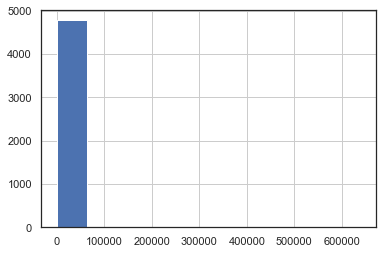

In [124]:
likes.actor_1_facebook_likes.hist()

Could probably use a log transform or something. Or is it just full of zeroes?

In [125]:
likes.actor_1_facebook_likes[likes.actor_1_facebook_likes < 5].shape

(36,)

In [126]:
likes.director_facebook_likes[likes.director_facebook_likes == 0].shape

(872,)

In [127]:
likes.director_facebook_likes.describe()

count     4803.000000
mean       692.601915
std       2836.009407
min          0.000000
25%          7.000000
50%         48.000000
75%        190.500000
max      23000.000000
Name: director_facebook_likes, dtype: float64

I'm willing to believe that directors are just generally not as popular as their actors

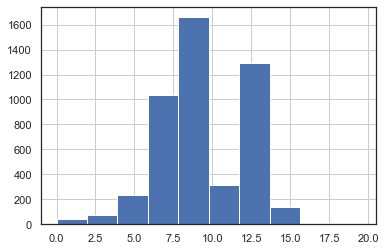

In [128]:
# +1 like for boxcox, does not like zeroes
pd.Series(boxcox(likes.actor_1_facebook_likes+1)[0]).hist()

Seems good

In [129]:
all_boxcoxed = [pd.Series(boxcox(likes[col]+1)[0], name=f"{col}_box") for col in likes.columns]

In [130]:
boxed_df = pd.concat(all_boxcoxed,axis=1)
boxed_df.index = df_encoded_genres.index
boxed_df.head()

,actor_1_facebook_likes_box,actor_2_facebook_likes_box,actor_3_facebook_likes_box,director_facebook_likes_box,cast_total_facebook_likes_box
imdb_id,,,,,
tt5215952,4.250035,1.917963,0.000000,3.648834,5.229121
tt5078326,7.488314,2.388995,1.198774,2.502277,10.108035
tt5001130,3.362001,1.461064,0.000000,4.556906,4.057789
tt4939066,12.467224,5.223879,4.491669,3.380737,19.933142
tt4871980,8.253012,7.951943,10.534436,3.082217,15.201223


actor_1_facebook_likes_box


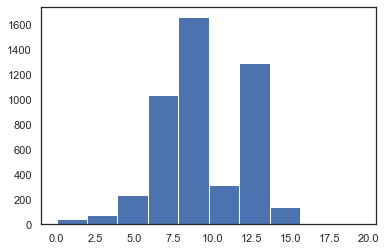

actor_2_facebook_likes_box


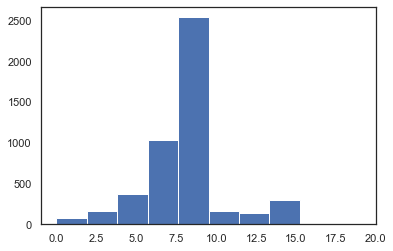

actor_3_facebook_likes_box


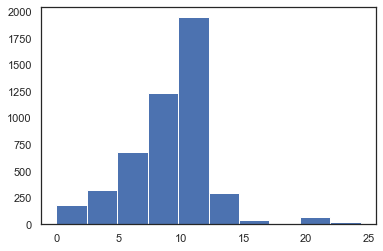

director_facebook_likes_box


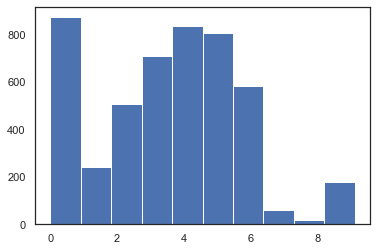

cast_total_facebook_likes_box


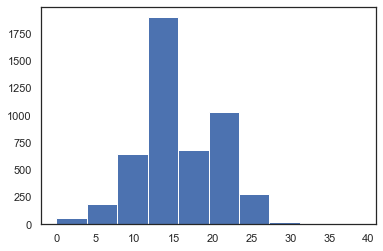

In [131]:
for col in boxed_df:
    plt.figure()
    plt.hist(boxed_df[col])
    print(col)
    plt.show()
del col

In [132]:
no_likes = df_encoded_genres.drop([col for col in df_encoded_genres if "likes" in col], axis=1)

In [133]:
boxed_df.index = no_likes.index

In [134]:
df_boxcoxed_likes = pd.concat([no_likes, boxed_df],axis=1)

In [135]:
df_boxcoxed_likes.head(3)

,original_language,color,title,movie_title,original_title,overview,content_rating,imdb_score,revenue,filled_budget,...,genre_Action,genre_Mystery,genre_Sci-Fi,genre_Adventure,genre_Documentary,actor_1_facebook_likes_box,actor_2_facebook_likes_box,actor_3_facebook_likes_box,director_facebook_likes_box,cast_total_facebook_likes_box
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,Other,Color,The Wailing,The Wailing,곡성,A stranger arrives in a little village and soo...,Unrated,7.7,47098491,10951000.0,...,0,1,0,0,0,4.250035,1.917963,0.000000,3.648834,5.229121
tt5078326,French,Color,The Country Doctor,Irreplaceable,Médecin de campagne,"All the people in this countryside area, can c...",PG-13,7.2,0,19000000.0,...,0,0,0,0,0,7.488314,2.388995,1.198774,2.502277,10.108035
tt5001130,English,Color,Time to Choose,Time to Choose,Time to Choose,Academy Award® winning director Charles Fergus...,PG-13,7.0,0,3500000.0,...,0,0,0,0,1,3.362001,1.461064,0.000000,4.556906,4.057789


### Budget

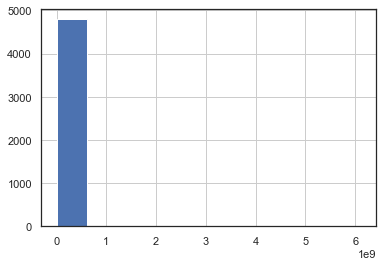

In [136]:
df_boxcoxed_likes.filled_budget.hist()

Also pretty skewed up

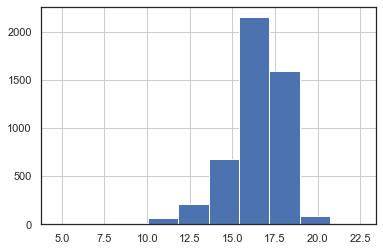

In [137]:
df_boxcoxed_likes.filled_budget.transform(np.log).hist()

Not perfect, boxcox again?

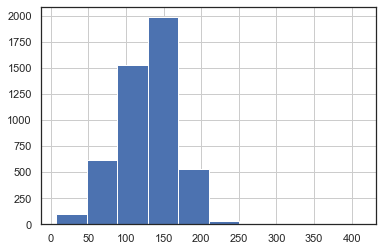

In [138]:
budget_boxed = pd.Series(boxcox(df_boxcoxed_likes.filled_budget)[0], name="budget_boxed")
budget_boxed.hist()

In [139]:
df_boxcoxed_budget = df_boxcoxed_likes.assign(budget_boxed=budget_boxed.values).drop(['filled_budget'],axis=1)

In [140]:
df_boxcoxed_budget.head()

,original_language,color,title,movie_title,original_title,overview,content_rating,imdb_score,revenue,fixed_aspect,...,genre_Mystery,genre_Sci-Fi,genre_Adventure,genre_Documentary,actor_1_facebook_likes_box,actor_2_facebook_likes_box,actor_3_facebook_likes_box,director_facebook_likes_box,cast_total_facebook_likes_box,budget_boxed
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,Other,Color,The Wailing,The Wailing,곡성,A stranger arrives in a little village and soo...,Unrated,7.7,47098491,2.39,...,1,0,0,0,4.250035,1.917963,0.000000,3.648834,5.229121,116.223876
tt5078326,French,Color,The Country Doctor,Irreplaceable,Médecin de campagne,"All the people in this countryside area, can c...",PG-13,7.2,0,1.85,...,0,0,0,0,7.488314,2.388995,1.198774,2.502277,10.108035,130.009231
tt5001130,English,Color,Time to Choose,Time to Choose,Time to Choose,Academy Award® winning director Charles Fergus...,PG-13,7.0,0,1.85,...,0,0,0,1,3.362001,1.461064,0.000000,4.556906,4.057789,91.992876
tt4939066,Other,Color,Operation Chromite,Operation Chromite,인천상륙작전,A squad of soldiers fight in the Korean War's ...,PG-13,6.8,49196532,1.85,...,0,0,0,0,12.467224,5.223879,4.491669,3.380737,19.933142,119.709388
tt4871980,English,Color,The Perfect Match,The Perfect Match,The Perfect Match,"Terrence J. stars as Charlie, a playboy who's ...",R,4.5,0,1.85,...,0,0,0,0,8.253012,7.951943,10.534436,3.082217,15.201223,98.998224


### Duration

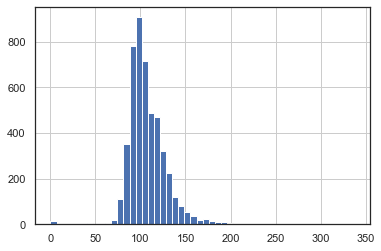

In [141]:
df_boxcoxed_budget.durations.hist(bins=50)

Seems pretty tightly clustered around feature length film length

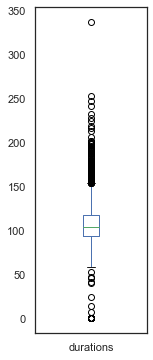

In [142]:
df_boxcoxed_budget.durations.plot(kind='box',figsize=(2,6))

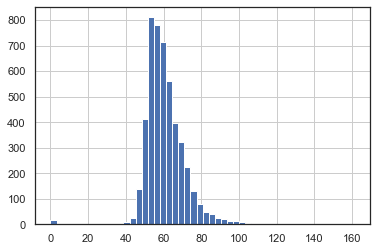

In [143]:
pd.Series(boxcox(df_boxcoxed_budget.durations+1)[0], name=f"duration_box").hist(bins=50)

I think we can just stick with the original durations, no transform needed.

### Number of Production Countries

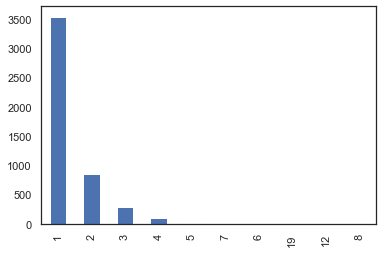

In [144]:
df_boxcoxed_budget.n_production_countries.value_counts().plot(kind='bar')

I should lump together 5+ perhaps...it gets a bit sparse

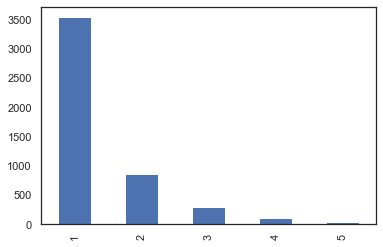

In [145]:
df_boxcoxed_budget.n_production_countries.apply(lambda x: 5 if x >= 5 else x).value_counts().plot(kind='bar')

In [146]:
df_boxcoxed_budget["n_prod_locs_trunc"] = df_boxcoxed_budget.n_production_countries.apply(
                                                                                    lambda x: 5 if x >= 5 else x
                                                                                )

We will need to remember that here, the int 5 represents 5 or more countries of filming.

In [147]:
del df_boxcoxed_budget["n_production_countries"]

### Revenue (Secondary Response Variable)

My understanding is that response variables do not need to be normally distributed, for regression.

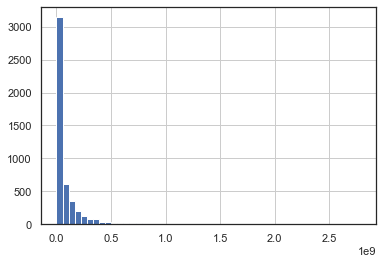

In [148]:
df_boxcoxed_budget.revenue.hist(bins=50)

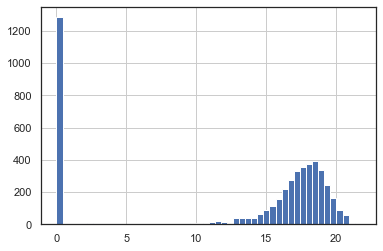

In [149]:
(df_boxcoxed_budget["revenue"]+1).transform(np.log).hist(bins=50)

Hrmm

### IMdB Score (Response Variable)

In [150]:
df_boxcoxed_budget.imdb_score.describe()

count    4803.000000
mean        6.412742
std         1.117837
min         1.600000
25%         5.800000
50%         6.500000
75%         7.200000
max         9.300000
Name: imdb_score, dtype: float64

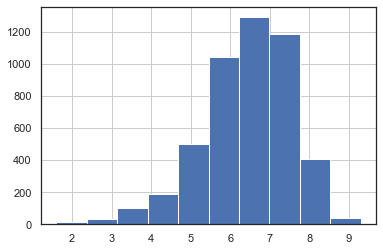

In [151]:
df_boxcoxed_budget.imdb_score.hist()

In [152]:
df_boxcoxed_budget.to_pickle("../data/pickles/df_boxcoxed_budget.pkl")

## Free Text Columns

In [153]:
df_boxcoxed_budget = pd.read_pickle("../data/pickles/df_boxcoxed_budget.pkl")

### Titles

In [154]:
titles = df_boxcoxed_budget["title movie_title original_title".split()]
titles.head(50)

,title,movie_title,original_title
imdb_id,,,
tt5215952,The Wailing,The Wailing,곡성
tt5078326,The Country Doctor,Irreplaceable,Médecin de campagne
tt5001130,Time to Choose,Time to Choose,Time to Choose
tt4939066,Operation Chromite,Operation Chromite,인천상륙작전
tt4871980,The Perfect Match,The Perfect Match,The Perfect Match
tt4824308,God's Not Dead 2,God's Not Dead 2,God's Not Dead 2
tt4786282,Lights Out,Lights Out,Lights Out
tt4733536,American Hero,American Hero,American Hero
tt4707756,The World Is Mine,The World Is Mine,Lumea e a mea


In [155]:
titles['title'].iloc[0] == titles["movie_title"].iloc[0]

False

In [156]:
titles['title'].iloc[0]

'The Wailing'

In [157]:
titles["movie_title"].iloc[0]

'The Wailing\xa0'

In [158]:
titles['movie_title'] = titles['movie_title'].apply(lambda title: normalize('NFKD', title).strip())

/Users/admin/.local/share/virtualenvs/Good-Film-Bad-Film-vaMlpeB4/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [159]:
titles['title'].iloc[0] == titles["movie_title"].iloc[0]

True

In [160]:
titles[titles.title != titles.movie_title].shape

(228, 3)

In [161]:
titles[titles.title != titles.movie_title].head(30)

,title,movie_title,original_title
imdb_id,,,
tt5078326,The Country Doctor,Irreplaceable,Médecin de campagne
tt4704314,To Be Frank: Sinatra at 100,"To Be Frank, Sinatra at 100",To Be Frank: Sinatra at 100
tt4591310,The Monkey King 2,Xi you ji zhi: Sun Wukong san da Baigu Jing,西游记之孙悟空三打白骨精
tt4590482,Karachi Se Lahore,Karachi se Lahore,کراچی سے لاہور
tt4374230,Juliet and Alfa Romeo,Julija in alfa Romeo,Julija in Alfa Romeo
tt4262980,Shin Godzilla,Godzilla Resurgence,シン・ゴジラ
tt4172430,13 Hours: The Secret Soldiers of Benghazi,13 Hours,13 Hours: The Secret Soldiers of Benghazi
tt4075322,Savva. Heart of the Warrior,A Warrior's Tail,Савва. Сердце воина
tt4061848,Alpha and Omega: The Legend of the Saw Tooth Cave,Alpha and Omega 4: The Legend of the Saw Tooth...,Alpha and Omega: The Legend of the Saw Tooth Cave


I can't tell just from looking which of these is the definitive "right" column to use. Original_title seems more likely to be in a foreign language...

In [162]:
titles[titles.title != titles.movie_title].tail(30)

,title,movie_title,original_title
imdb_id,,,
tt0108500,The Visitors,Les visiteurs,Les Visiteurs
tt0107953,Return of the Living Dead 3,Return of the Living Dead III,Return of the Living Dead 3
tt0107659,National Lampoon's Loaded Weapon 1,Loaded Weapon 1,National Lampoon's Loaded Weapon 1
tt0106469,Bound by Honor,"Blood In, Blood Out",Bound by Honor
tt0103874,Dracula,Bram Stoker's Dracula,Dracula
tt0103644,Alien³,Alien 3,Alien³
tt0102510,The Naked Gun 2½: The Smell of Fear,The Naked Gun 21⁄2: The Smell of Fear,The Naked Gun 2½: The Smell of Fear
tt0099685,GoodFellas,Goodfellas,GoodFellas
tt0098724,"sex, lies, and videotape","Sex, Lies, and Videotape","sex, lies, and videotape"


I don't think there is going to be predictive information in the title itself. Maybe I'll just grab one as a plaintext reference to the datapoint...

In [163]:
df_boxcoxed_budget.drop(['movie_title', "original_title"],axis=1,inplace=True)

In [164]:
del titles

### Overview / Plot Synopsis

This is where we need to get into real NLP stuff.

Let's have a peek at our plots:

In [165]:
[print(_,"\n") for _ in df_boxcoxed_budget.overview.head(10)]

A stranger arrives in a little village and soon after a mysterious sickness starts spreading. A policeman is drawn into the incident and is forced to solve the mystery in order to save his daughter. 

All the people in this countryside area, can count on Jean-Pierre, the doctor who auscultates them, heals and reassures them day and night, 7 days a week. Now Jean-Pierre is sick, so he sees Natalie, a young doctor, coming from the hospital to assist him. But will she adapt to this new life and be able to replace the man that believed to be irreplaceable? 

Academy Award® winning director Charles Ferguson's new film investigates global climate change villains and heroes, and reveals practical solutions to act on. 

A squad of soldiers fight in the Korean War's crucial Battle of Incheon. 

Terrence J. stars as Charlie, a playboy who's convinced that relationships are dead. His two best friends, Donald Faison and Robert C. Riley, bet him that if he sticks to one woman for one month, he's bo

[None, None, None, None, None, None, None, None, None, None]

#### Removing stopwords, POS lemmatization

In [166]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def process_plot(plot):
    tokens = word_tokenize(plot)
    stops_removed = [w for w in tokens if w not in stop_words]
    punc_removed = [w.lower() for w in stops_removed if w.isalpha()]
    tagged = [(w, get_wordnet_pos(w)) for w in punc_removed]
    return " ".join([lemmatizer.lemmatize(word[0], pos=word[1]) for word in tagged])

In [167]:
df_boxcoxed_budget['plot_prepped'] = df_boxcoxed_budget.overview.apply(process_plot)

#### Binary Count Vectorizing, TF-IDF Normalizing

From the [sklearn docs](https://scikit-learn.org/stable/modules/feature_extraction.html#):

"The word boundaries-aware variant `char_wb` is especially interesting for languages that use white-spaces for word separation...as it...can increase both the predictive accuracy and convergence speed of classifiers trained using such features while retaining the robustness with regards to misspellings and word derivations."

In [168]:
bigram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(5, 5),#ngram_range=(1, 2),
                                    token_pattern=r'\b\w+\b', 
                                    min_df=1,
                                    binary=True)

# Plot synopsis texts are not very long: Using binary countvectorizer to help reduce noise

In [169]:
bigram_vectorizer

CountVectorizer(analyzer='char_wb', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(5, 5), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='\\b\\w+\\b', tokenizer=None,
                vocabulary=None)

In [170]:
analyze = bigram_vectorizer.build_analyzer()
analyze('Bi-grams are cool!')

[' bi-g',
 'bi-gr',
 'i-gra',
 '-gram',
 'grams',
 'rams ',
 ' are ',
 ' cool',
 'cool!',
 'ool! ']

In [171]:
sparse_plots = bigram_vectorizer.fit_transform(df_boxcoxed_budget['plot_prepped'])
sparse_plots

<4803x40742 sparse matrix of type '<class 'numpy.int64'>'
	with 487817 stored elements in Compressed Sparse Row format>

In [172]:
bigram_columns = bigram_vectorizer.get_feature_names()

In [173]:
bigram_counts = pd.DataFrame(sparse_plots.toarray(),
                             columns=bigram_columns)

bigram_counts.head()

,a,aa,aaa,aame,aang,aaro,aba,abad,abag,aban,...,érôme,ésar,örgy,öves,ørgen,única,ührer,ürren,ładys,ﬁcial
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(bigram_counts)

In [175]:
df_tfidf = pd.DataFrame(tfidf.toarray(), columns=bigram_columns)
df_tfidf.head()

,a,aa,aaa,aame,aang,aaro,aba,abad,abag,aban,...,érôme,ésar,örgy,öves,ørgen,única,ührer,ürren,ładys,ﬁcial
0,0.052352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.065157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [176]:
del bigram_columns
del bigram_counts
del stop_words
del analyze
del df_boxcoxed_budget['overview']
del df_boxcoxed_budget['plot_prepped']
del tfidf
del transformer
del wordnet
del lemmatizer
del languages
del sparse_plots
del bigram_vectorizer
del stopwords

In [177]:
df_tfidf.columns[:100]

Index([' a ', ' aa ', ' aaa ', ' aame', ' aang', ' aaro', ' aba ', ' abad',
       ' abag', ' aban', ' abba', ' abbe', ' abbi', ' abbo', ' abby', ' abdi',
       ' abdu', ' abe ', ' abel', ' aber', ' abho', ' abid', ' abig', ' abil',
       ' abla', ' able', ' aboa', ' abod', ' abol', ' abor', ' abou', ' abra',
       ' abro', ' abru', ' abse', ' absh', ' abso', ' abst', ' absu', ' abu ',
       ' abun', ' abus', ' abys', ' acad', ' acap', ' acce', ' acci', ' accl',
       ' acco', ' accr', ' accu', ' ace ', ' ache', ' achi', ' acke', ' acme',
       ' acp ', ' acqu', ' acre', ' acri', ' acro', ' act ', ' acti', ' acto',
       ' actr', ' actu', ' acut', ' ad ', ' ada ', ' adal', ' adam', ' adap',
       ' add ', ' adda', ' addi', ' addr', ' adel', ' adep', ' adib', ' adit',
       ' adja', ' adju', ' adle', ' adm ', ' admi', ' admo', ' adol', ' adon',
       ' adop', ' ador', ' adre', ' adri', ' adul', ' adva', ' adve', ' advi',
       ' advo', ' aegi', ' aeri', ' afar'],
      dtype=

In [178]:
df_tfidf.columns[5000:5100]

Index([' payc', ' payd', ' paym', ' payn', ' payo', ' peac', ' peak', ' pean',
       ' pear', ' peas', ' pebb', ' peck', ' pecu', ' pedd', ' pede', ' pedl',
       ' pedo', ' pedr', ' pee ', ' peeb', ' peek', ' peel', ' peep', ' peer',
       ' peet', ' pegg', ' pei ', ' peka', ' peki', ' pele', ' peli', ' pelt',
       ' pen ', ' pena', ' penc', ' pend', ' pene', ' peng', ' peni', ' penl',
       ' penn', ' pens', ' pent', ' peop', ' pepp', ' pequ', ' per ', ' pera',
       ' perc', ' perd', ' pere', ' perf', ' perh', ' peri', ' perk', ' perm',
       ' pern', ' pero', ' perp', ' perr', ' pers', ' pert', ' peru', ' perv',
       ' peró', ' pesc', ' pesk', ' pest', ' pet ', ' peta', ' pete', ' peti',
       ' petr', ' pett', ' peve', ' peyt', ' pfei', ' pga ', ' phal', ' phan',
       ' phar', ' phas', ' phel', ' phen', ' phi ', ' phil', ' phin', ' phob',
       ' phoe', ' phon', ' phot', ' phra', ' phys', ' pi ', ' pian', ' pica',
       ' picc', ' pick', ' pict', ' pie '],
      dty

In [179]:
df_tfidf.shape

(4803, 40742)

Pretty large feature space there. Maybe I'll incorporate some PCA in the modeling pipeline...

In [180]:
df_boxcoxed_budget.head()

,original_language,color,title,content_rating,imdb_score,revenue,fixed_aspect,durations,shot_only_in_USA,shot_in_USA_and_abroad,...,genre_Sci-Fi,genre_Adventure,genre_Documentary,actor_1_facebook_likes_box,actor_2_facebook_likes_box,actor_3_facebook_likes_box,director_facebook_likes_box,cast_total_facebook_likes_box,budget_boxed,n_prod_locs_trunc
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,Other,Color,The Wailing,Unrated,7.7,47098491,2.39,156.0,1,0,...,0,0,0,4.250035,1.917963,0.000000,3.648834,5.229121,116.223876,1
tt5078326,French,Color,The Country Doctor,PG-13,7.2,0,1.85,102.0,1,0,...,0,0,0,7.488314,2.388995,1.198774,2.502277,10.108035,130.009231,1
tt5001130,English,Color,Time to Choose,PG-13,7.0,0,1.85,100.0,0,0,...,0,0,1,3.362001,1.461064,0.000000,4.556906,4.057789,91.992876,1
tt4939066,Other,Color,Operation Chromite,PG-13,6.8,49196532,1.85,111.0,1,0,...,0,0,0,12.467224,5.223879,4.491669,3.380737,19.933142,119.709388,1
tt4871980,English,Color,The Perfect Match,R,4.5,0,1.85,96.0,0,0,...,0,0,0,8.253012,7.951943,10.534436,3.082217,15.201223,98.998224,1


In [181]:
df_boxcoxed_budget.shape

(4803, 28)

In [182]:
df_boxcoxed_budget.columns

Index(['original_language', 'color', 'title', 'content_rating', 'imdb_score',
       'revenue', 'fixed_aspect', 'durations', 'shot_only_in_USA',
       'shot_in_USA_and_abroad', 'genre_Drama', 'genre_Comedy',
       'genre_Romance', 'genre_Crime', 'genre_Thriller', 'genre_Horror',
       'genre_Action', 'genre_Mystery', 'genre_Sci-Fi', 'genre_Adventure',
       'genre_Documentary', 'actor_1_facebook_likes_box',
       'actor_2_facebook_likes_box', 'actor_3_facebook_likes_box',
       'director_facebook_likes_box', 'cast_total_facebook_likes_box',
       'budget_boxed', 'n_prod_locs_trunc'],
      dtype='object')

In [183]:
df_boxcoxed_budget.to_pickle('../data/pickles/df_mostly_ready_metadata.pkl')
df_tfidf.to_pickle('../data/pickles/df_tfidf.pkl')

***

# Feature Engineering

## Encoding Everything

In [184]:
df_mostly_ready_metadata = pd.read_pickle('../data/pickles/df_mostly_ready_metadata.pkl')

In [185]:
df_mostly_ready_metadata.head(3)

,original_language,color,title,content_rating,imdb_score,revenue,fixed_aspect,durations,shot_only_in_USA,shot_in_USA_and_abroad,...,genre_Sci-Fi,genre_Adventure,genre_Documentary,actor_1_facebook_likes_box,actor_2_facebook_likes_box,actor_3_facebook_likes_box,director_facebook_likes_box,cast_total_facebook_likes_box,budget_boxed,n_prod_locs_trunc
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,Other,Color,The Wailing,Unrated,7.7,47098491,2.39,156.0,1,0,...,0,0,0,4.250035,1.917963,0.000000,3.648834,5.229121,116.223876,1
tt5078326,French,Color,The Country Doctor,PG-13,7.2,0,1.85,102.0,1,0,...,0,0,0,7.488314,2.388995,1.198774,2.502277,10.108035,130.009231,1
tt5001130,English,Color,Time to Choose,PG-13,7.0,0,1.85,100.0,0,0,...,0,0,1,3.362001,1.461064,0.000000,4.556906,4.057789,91.992876,1


In [186]:
df_mostly_ready_metadata.dtypes

original_language                  object
color                              object
title                              object
content_rating                     object
imdb_score                        float64
revenue                             int64
fixed_aspect                     category
durations                         float64
shot_only_in_USA                    int64
shot_in_USA_and_abroad              int64
genre_Drama                         int64
genre_Comedy                        int64
genre_Romance                       int64
genre_Crime                         int64
genre_Thriller                      int64
genre_Horror                        int64
genre_Action                        int64
genre_Mystery                       int64
genre_Sci-Fi                        int64
genre_Adventure                     int64
genre_Documentary                   int64
actor_1_facebook_likes_box        float64
actor_2_facebook_likes_box        float64
actor_3_facebook_likes_box        

In [187]:
lang_matrix = pd.get_dummies(df_mostly_ready_metadata['original_language'],
                             prefix="lang")
lang_matrix.head()

,lang_English,lang_French,lang_Other,lang_Spanish
imdb_id,,,,
tt5215952,0,0,1,0
tt5078326,0,1,0,0
tt5001130,1,0,0,0
tt4939066,0,0,1,0
tt4871980,1,0,0,0


In [188]:
df_mostly_ready_metadata.drop(['original_language'],axis=1,inplace=True)

In [189]:
df_mostly_ready_metadata = pd.concat([df_mostly_ready_metadata, 
                                      lang_matrix],axis=1)

In [190]:
df_mostly_ready_metadata['color'] = df_mostly_ready_metadata['color'].map({"Color":1,
                                                                           "Black and White":0})

df_mostly_ready_metadata.head()

,color,title,content_rating,imdb_score,revenue,fixed_aspect,durations,shot_only_in_USA,shot_in_USA_and_abroad,genre_Drama,...,actor_2_facebook_likes_box,actor_3_facebook_likes_box,director_facebook_likes_box,cast_total_facebook_likes_box,budget_boxed,n_prod_locs_trunc,lang_English,lang_French,lang_Other,lang_Spanish
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,1,The Wailing,Unrated,7.7,47098491,2.39,156.0,1,0,0,...,1.917963,0.000000,3.648834,5.229121,116.223876,1,0,0,1,0
tt5078326,1,The Country Doctor,PG-13,7.2,0,1.85,102.0,1,0,1,...,2.388995,1.198774,2.502277,10.108035,130.009231,1,0,1,0,0
tt5001130,1,Time to Choose,PG-13,7.0,0,1.85,100.0,0,0,0,...,1.461064,0.000000,4.556906,4.057789,91.992876,1,1,0,0,0
tt4939066,1,Operation Chromite,PG-13,6.8,49196532,1.85,111.0,1,0,1,...,5.223879,4.491669,3.380737,19.933142,119.709388,1,0,0,1,0
tt4871980,1,The Perfect Match,R,4.5,0,1.85,96.0,0,0,0,...,7.951943,10.534436,3.082217,15.201223,98.998224,1,1,0,0,0


In [191]:
del df_mostly_ready_metadata['title']

In [192]:
df_some_binarized = pd.concat([df_mostly_ready_metadata.drop(['fixed_aspect'],axis=1), 
                                pd.get_dummies(df_mostly_ready_metadata.fixed_aspect, prefix="ratio")],axis=1
                              )

In [193]:
del df_mostly_ready_metadata

In [194]:
df_some_binarized.head()

,color,content_rating,imdb_score,revenue,durations,shot_only_in_USA,shot_in_USA_and_abroad,genre_Drama,genre_Comedy,genre_Romance,...,budget_boxed,n_prod_locs_trunc,lang_English,lang_French,lang_Other,lang_Spanish,ratio_1.33,ratio_1.77,ratio_1.85,ratio_2.39
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,1,Unrated,7.7,47098491,156.0,1,0,0,0,0,...,116.223876,1,0,0,1,0,0,0,0,1
tt5078326,1,PG-13,7.2,0,102.0,1,0,1,1,0,...,130.009231,1,0,1,0,0,0,0,1,0
tt5001130,1,PG-13,7.0,0,100.0,0,0,0,0,0,...,91.992876,1,1,0,0,0,0,0,1,0
tt4939066,1,PG-13,6.8,49196532,111.0,1,0,1,0,0,...,119.709388,1,0,0,1,0,0,0,1,0
tt4871980,1,R,4.5,0,96.0,0,0,0,1,1,...,98.998224,1,1,0,0,0,0,0,1,0


In [195]:
content_ratings = pd.get_dummies(df_some_binarized.content_rating,prefix="content")
content_ratings.head(3)

,content_PG,content_PG-13,content_R,content_Unrated,content_X
imdb_id,,,,,
tt5215952,0,0,0,1,0
tt5078326,0,1,0,0,0
tt5001130,0,1,0,0,0


In [196]:
df_ratings_binarized = pd.concat([df_some_binarized.drop(['content_rating'],
                                                         axis=1
                                                        ), 
                                  content_ratings],
                                  axis=1
                                )

In [197]:
del content_ratings
del df_some_binarized

In [198]:
df_ratings_binarized.head()

,color,imdb_score,revenue,durations,shot_only_in_USA,shot_in_USA_and_abroad,genre_Drama,genre_Comedy,genre_Romance,genre_Crime,...,lang_Spanish,ratio_1.33,ratio_1.77,ratio_1.85,ratio_2.39,content_PG,content_PG-13,content_R,content_Unrated,content_X
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,1,7.7,47098491,156.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
tt5078326,1,7.2,0,102.0,1,0,1,1,0,0,...,0,0,0,1,0,0,1,0,0,0
tt5001130,1,7.0,0,100.0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
tt4939066,1,6.8,49196532,111.0,1,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
tt4871980,1,4.5,0,96.0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,0


In [199]:
df_ratings_binarized.to_pickle('../data/pickles/df_structured.pkl')

## Separate X and y

In [200]:
df_structured = pd.read_pickle('../data/pickles/df_structured.pkl')
df_tfidf = pd.read_pickle('../data/pickles/df_tfidf.pkl')

df_tfidf.index = df_structured.index

df_structured.head()

,color,imdb_score,revenue,durations,shot_only_in_USA,shot_in_USA_and_abroad,genre_Drama,genre_Comedy,genre_Romance,genre_Crime,...,lang_Spanish,ratio_1.33,ratio_1.77,ratio_1.85,ratio_2.39,content_PG,content_PG-13,content_R,content_Unrated,content_X
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,1,7.7,47098491,156.0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
tt5078326,1,7.2,0,102.0,1,0,1,1,0,0,...,0,0,0,1,0,0,1,0,0,0
tt5001130,1,7.0,0,100.0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
tt4939066,1,6.8,49196532,111.0,1,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
tt4871980,1,4.5,0,96.0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,1,0,0


In [201]:
df_tfidf.head()

,a,aa,aaa,aame,aang,aaro,aba,abad,abag,aban,...,érôme,ésar,örgy,öves,ørgen,única,ührer,ürren,ładys,ﬁcial
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,0.052352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt5078326,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt5001130,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt4939066,0.065157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt4871980,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
y_colnames = ['revenue', 'imdb_score']

X_structured = df_structured.drop(y_colnames,axis=1)

y_structured = df_structured[y_colnames]

y_structured

,revenue,imdb_score
imdb_id,,
tt5215952,47098491,7.7
tt5078326,0,7.2
tt5001130,0,7.0
tt4939066,49196532,6.8
tt4871980,0,4.5
...,...,...
tt0018737,0,8.0
tt0017136,650422,8.3
tt0015624,22000000,8.3


In [203]:
X_structured

,color,durations,shot_only_in_USA,shot_in_USA_and_abroad,genre_Drama,genre_Comedy,genre_Romance,genre_Crime,genre_Thriller,genre_Horror,...,lang_Spanish,ratio_1.33,ratio_1.77,ratio_1.85,ratio_2.39,content_PG,content_PG-13,content_R,content_Unrated,content_X
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,1,156.0,1,0,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,1,0
tt5078326,1,102.0,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
tt5001130,1,100.0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
tt4939066,1,111.0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
tt4871980,1,96.0,0,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0018737,0,131.0,1,0,1,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,0
tt0017136,0,153.0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
tt0015624,0,151.0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


## Train / Test Split

Do not fit the scaler on the test set. Do not fit PCA on test set. Do not do feature nor model selection based on anything in the test set.

In [204]:
X_struct_train, X_struct_test, y_train, y_test = train_test_split(X_structured, 
                                                                  y_structured, 
                                                                  test_size=0.3, 
                                                                  shuffle=True,
                                                                  random_state=42)

I think my approach is going to be to use an ensemble to combine two regressors, one for the structured data and one for the unstructured plot texts

In [205]:
X_plots_train = df_tfidf.loc[y_train.index]
X_plots_test = df_tfidf.loc[y_test.index]

In [206]:
del y_structured
del df_structured
del df_tfidf

In [207]:
X_plots_train.to_pickle('../data/pickles/X_plots_train.pkl')
X_plots_test.to_pickle('../data/pickles/X_plots_test.pkl')

X_struct_train.to_pickle("../data/pickles/X_struct_train.pkl")
X_struct_test.to_pickle("../data/pickles/X_struct_test.pkl")

y_train.to_pickle('../data/pickles/y_train.pkl')
y_test.to_pickle('../data/pickles/y_test.pkl')

In [208]:
del X_plots_train
del X_plots_test

## Checking for Multicollinearity

In [209]:
X_struct_train = pd.read_pickle("../data/pickles/X_struct_train.pkl")
X_struct_test = pd.read_pickle("../data/pickles/X_struct_test.pkl")

In [210]:
X_plots_train = pd.read_pickle('../data/pickles/X_plots_train.pkl')
X_plots_test = pd.read_pickle('../data/pickles/X_plots_test.pkl')
y_train = pd.read_pickle('../data/pickles/y_train.pkl')
y_test = pd.read_pickle('../data/pickles/y_test.pkl')

Are there any redundant features? Are there any features obviously correlated with our dependent var?

In [211]:
def draw_correlation_heatmap(features):
    # Creating a multi-scatter plot
    corr =  features.corr()
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, 
                mask=mask, 
                cmap=cmap,
                vmax=1, 
                center=0,
                square=True, 
                linewidths=.5, 
                cbar_kws={"shrink": .5}).plot()

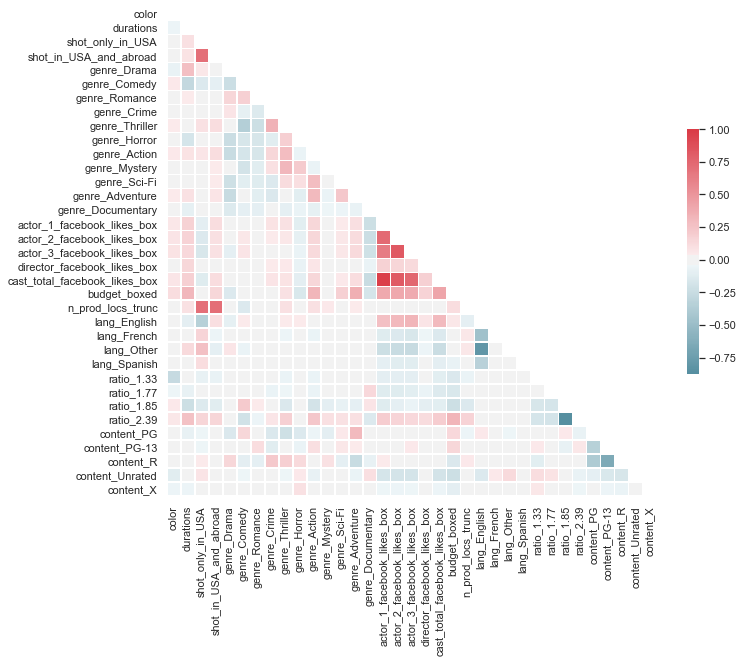

In [212]:
draw_correlation_heatmap(X_struct_train)

We have some obviously multicollinear features to lose.

In [213]:
multicollinear_features = ["shot_only_in_USA", 
                           "shot_in_USA_and_abroad", 
                           "cast_total_facebook_likes_box",
                           "actor_2_facebook_likes_box",
                           "actor_3_facebook_likes_box",
                           "lang_Other",
                           "ratio_1.85",
                           "content_PG-13"]

In [214]:
X_struct_train.drop(multicollinear_features, axis=1, inplace=True)

# Drop from the test set as well, to maintain same dimensionality
X_struct_test.drop(multicollinear_features, axis=1, inplace=True)

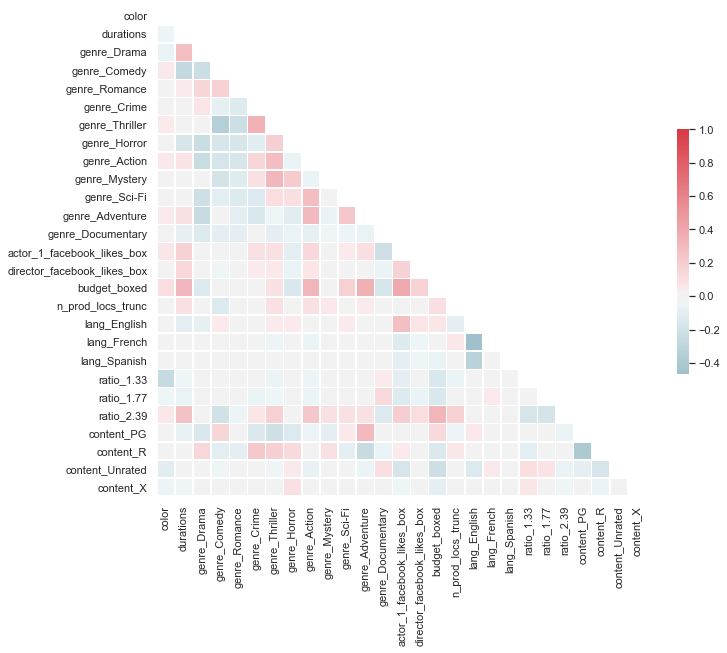

In [215]:
draw_correlation_heatmap(X_struct_train)

Better! I would use a more mathematically rigorous feature elimination technique, but honestly I'm just planning to try regression models with inherent feature elimination like lasso and random forest.

## Generating Interaction Variables

Now that we've removed the most obviously redundant terms, it might be helpful to generate a number of interaction terms, in case their interplay has some special significance

In [216]:
poly = PolynomialFeatures(2, 
                          interaction_only=True,
                          include_bias=False)

In [217]:
poly.fit(X_struct_train)

PolynomialFeatures(degree=2, include_bias=False, interaction_only=True,
                   order='C')

In [218]:
interaction_term_names = ["*".join(col.split()) for col in poly.get_feature_names(X_struct_train.columns)]

In [219]:
X_struct_train_poly = pd.DataFrame(poly.transform(X_struct_train), 
                                   columns = interaction_term_names,
                                   index = X_struct_train.index)

In [220]:
X_struct_test_poly = pd.DataFrame(poly.transform(X_struct_test), 
                                  columns = interaction_term_names,
                                  index = X_struct_test.index)

In [221]:
del X_struct_test
del X_struct_train
del X_structured
del interaction_term_names
del multicollinear_features

In [222]:
X_struct_train_poly.to_pickle('../data/pickles/X_struct_train_poly.pkl')
X_struct_test_poly.to_pickle('../data/pickles/X_struct_test_poly.pkl')

## Scaling Features

Load data:

In [223]:
X_struct_train_poly = pd.read_pickle('../data/pickles/X_struct_train_poly.pkl')
X_struct_test_poly = pd.read_pickle('../data/pickles/X_struct_test_poly.pkl')
X_plots_train = pd.read_pickle('../data/pickles/X_plots_train.pkl')
X_plots_test = pd.read_pickle('../data/pickles/X_plots_test.pkl')

Make 2 scalers:

In [224]:
struct_scaler = MinMaxScaler()
plots_scaler = MinMaxScaler()

Fit scaler on training set, apply to both training and testing sets:

In [225]:
X_struct_train_poly_scaled = pd.DataFrame(struct_scaler.fit_transform(X_struct_train_poly), 
                                         columns = X_struct_train_poly.columns,
                                         index = X_struct_train_poly.index)

X_struct_train_poly_scaled.head()

,color,durations,genre_Drama,genre_Comedy,genre_Romance,genre_Crime,genre_Thriller,genre_Horror,genre_Action,genre_Mystery,...,ratio_2.39*content_PG,ratio_2.39*content_R,ratio_2.39*content_Unrated,ratio_2.39*content_X,content_PG*content_R,content_PG*content_Unrated,content_PG*content_X,content_R*content_Unrated,content_R*content_X,content_Unrated*content_X
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0305669,1.0,0.310651,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0286112,0.0,0.334320,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0171363,1.0,0.334320,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0450259,1.0,0.423077,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0101507,1.0,0.331361,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [226]:
# Just transform() test set, not fit_transform()
X_struct_test_poly_scaled = pd.DataFrame(struct_scaler.transform(X_struct_test_poly), 
                                         columns = X_struct_test_poly.columns,
                                         index = X_struct_test_poly.index)

X_struct_test_poly_scaled.head()

,color,durations,genre_Drama,genre_Comedy,genre_Romance,genre_Crime,genre_Thriller,genre_Horror,genre_Action,genre_Mystery,...,ratio_2.39*content_PG,ratio_2.39*content_R,ratio_2.39*content_Unrated,ratio_2.39*content_X,content_PG*content_R,content_PG*content_Unrated,content_PG*content_X,content_R*content_Unrated,content_R*content_X,content_Unrated*content_X
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt1921064,1.0,0.310651,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0187393,1.0,0.488166,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0338348,1.0,0.295858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0382077,1.0,0.298817,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt4707756,1.0,0.307692,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [227]:
del X_struct_test_poly
del X_struct_train_poly

Also for plot synopsis data:

In [228]:
X_plots_train_scaled = pd.DataFrame(plots_scaler.fit_transform(X_plots_train), 
                                    columns = X_plots_train.columns,
                                    index = X_plots_train.index)

X_plots_train_scaled

,a,aa,aaa,aame,aang,aaro,aba,abad,abag,aban,...,érôme,ésar,örgy,öves,ørgen,única,ührer,ürren,ładys,ﬁcial
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt0305669,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0286112,0.373422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0171363,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0450259,0.227981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0101507,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt0087995,0.372291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt2147225,0.221066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0264796,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
# Again— only transform(), no fit_transform() here
X_plots_test_scaled = pd.DataFrame(plots_scaler.transform(X_plots_test), 
                                   columns = X_plots_test.columns,
                                   index = X_plots_test.index)

X_plots_test_scaled

,a,aa,aaa,aame,aang,aaro,aba,abad,abag,aban,...,érôme,ésar,örgy,öves,ørgen,única,ührer,ürren,ładys,ﬁcial
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt1921064,0.218945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0187393,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0338348,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0382077,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt4707756,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt3892618,0.238289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0388482,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0469263,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [230]:
del X_plots_test
del X_plots_train

Pickles:

In [231]:
X_plots_train_scaled.to_pickle("../data/pickles/X_plots_train_scaled.pkl")
X_plots_test_scaled.to_pickle('../data/pickles/X_plots_test_scaled.pkl')

X_struct_train_poly_scaled.to_pickle("../data/pickles/X_struct_train_poly_scaled.pkl")
X_struct_test_poly_scaled.to_pickle("../data/pickles/X_struct_test_poly_scaled.pkl")

# Model Building / Benchmarking

In [232]:
X_struct_train_poly_scaled = pd.read_pickle("../data/pickles/X_struct_train_poly_scaled.pkl")
X_struct_test_poly_scaled = pd.read_pickle("../data/pickles/X_struct_test_poly_scaled.pkl")

y_train = pd.read_pickle('../data/pickles/y_train.pkl')
y_test = pd.read_pickle('../data/pickles/y_test.pkl')

X_struct_train_poly_scaled.shape[0], X_struct_test_poly_scaled.shape[0]

(3362, 1441)

In [233]:
y_train.shape[0], y_test.shape[0]

(3362, 1441)

## Baselining

In [234]:
def get_error_metrics(y_actual, y_preds, name, draw_errors=True):
    ys = (y_actual, y_preds)
    metrics = dict()
    metrics["r^2"] = r2_score(*ys)
    metrics["RMSE"] = np.sqrt(mean_squared_error(*ys))
    metrics["Med_AE"] = median_absolute_error(*ys) # Nicely robust to outliers
    not_rounded_metrics = {k:v for k,v in metrics.items()}
    if draw_errors:
        (y_actual - y_preds).hist(bins=20)
    return pd.Series(not_rounded_metrics, name=name)

### Dummy Regressor

Very very naive model

In [235]:
dummy_regr_critics = DummyRegressor(strategy="median")
dummy_regr_revenue = DummyRegressor(strategy="mean")

dummy_regr_critics.fit(X_struct_train_poly_scaled, y_train.imdb_score)
dummy_regr_revenue.fit(X_struct_train_poly_scaled, y_train.revenue)

ypred_critics_dummy = pd.Series(dummy_regr_critics.predict(X_struct_test_poly_scaled),
                                index=y_test.index)

ypred_revenue_dummy = pd.Series(dummy_regr_revenue.predict(X_struct_test_poly_scaled),
                                index=y_test.index)

r^2      -0.029353
RMSE      1.099707
Med_AE    0.700000
Name: critics_dummy, dtype: float64

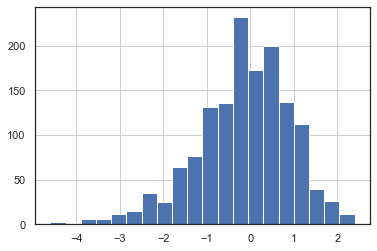

In [236]:
scores_critics_dummy = get_error_metrics(y_test.imdb_score, ypred_critics_dummy, "critics_dummy")
scores_critics_dummy

r^2      -1.262974e-04
RMSE      1.608384e+08
Med_AE    8.025393e+07
Name: revenue_dummy, dtype: float64

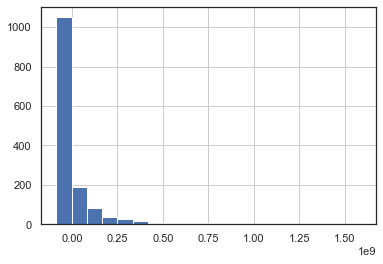

In [237]:
scores_revenue_dummy = get_error_metrics(y_test.revenue, ypred_revenue_dummy, "revenue_dummy")
scores_revenue_dummy

## Model Building

Let's start with a linear regressor, but one that can prune out seemingly irrelevant features:

### Linear: Lasso Regression

In [238]:
lasso_regr_critics = LassoCV(cv=5, random_state=0)
lasso_regr_revenue = LassoCV(cv=5, random_state=0)

lasso_regr_critics.fit(X_struct_train_poly_scaled, y_train.imdb_score)
lasso_regr_revenue.fit(X_struct_train_poly_scaled, y_train.revenue)

ypred_critics_lasso = pd.Series(lasso_regr_critics.predict(X_struct_test_poly_scaled),
                                index=y_test.index)


ypred_revenue_lasso = pd.Series(lasso_regr_revenue.predict(X_struct_test_poly_scaled),
                                index=y_test.index)

del lasso_regr_revenue

r^2       0.267326
RMSE      0.927790
Med_AE    0.555232
Name: critics_lasso, dtype: float64

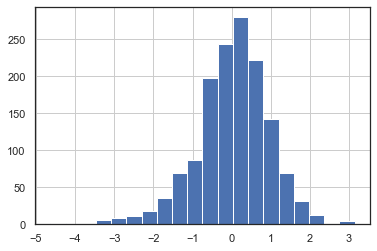

In [239]:
scores_critics_lasso = get_error_metrics(y_test.imdb_score, 
                                         ypred_critics_lasso, 
                                         "critics_lasso")
del ypred_critics_lasso

scores_critics_lasso

Wow kinda decent at predicting critic scores.

In [240]:
pd.DataFrame([scores_critics_dummy,scores_critics_lasso,])

,r^2,RMSE,Med_AE
critics_dummy,-0.029353,1.099707,0.700000
critics_lasso,0.267326,0.927790,0.555232


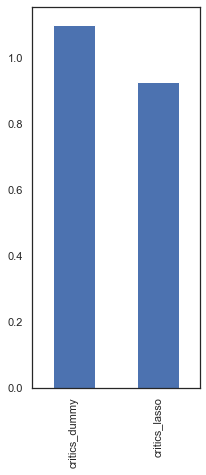

In [241]:
pd.DataFrame([scores_critics_dummy,scores_critics_lasso,]).RMSE.plot(kind='bar',figsize=(3,7))

In [242]:
lasso_coefs = pd.Series(lasso_regr_critics.coef_, 
                        index=X_struct_test_poly_scaled.columns).sort_values()

lasso_coefs_larger = lasso_coefs[abs(lasso_coefs) > .3]

[]

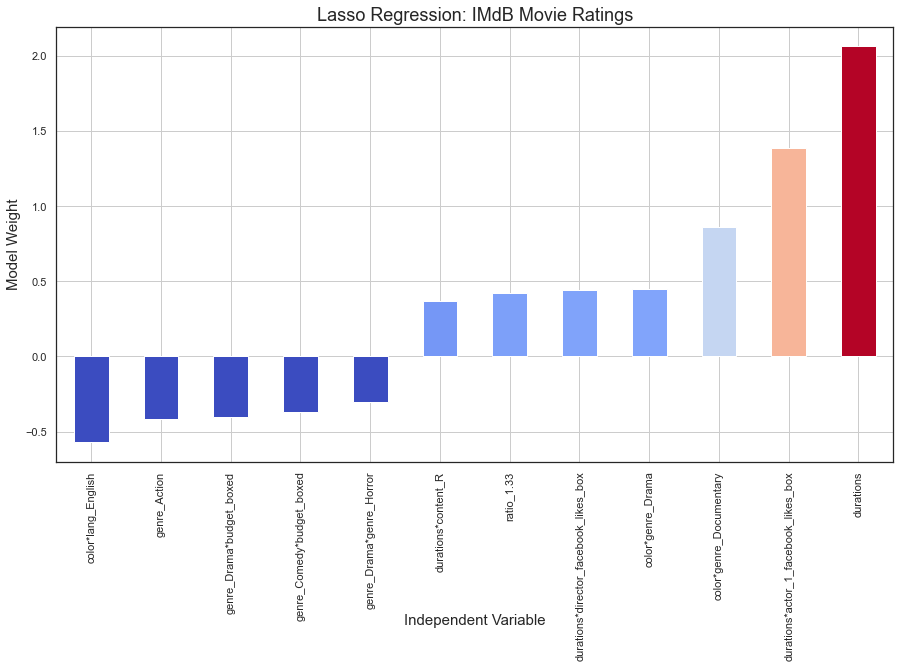

In [243]:
data_color = [x / max(lasso_coefs_larger) for x in lasso_coefs_larger]
my_cmap = plt.cm.get_cmap('coolwarm')
colors = my_cmap(data_color)

ax = lasso_coefs_larger.plot(kind='bar', 
                        figsize=(15,8),
                        grid=True,
                        color = colors,
                        )

ax.set_xlabel("Independent Variable", fontsize=15)
ax.set_ylabel("Model Weight", fontsize=15)
ax.set_title("Lasso Regression: IMdB Movie Ratings", fontsize=18)
ax.xaxis.set_label_coords(.5, -0.35)
ax.plot()

r^2       5.125039e-01
RMSE      1.122917e+08
Med_AE    3.807426e+07
Name: revenue_lasso, dtype: float64

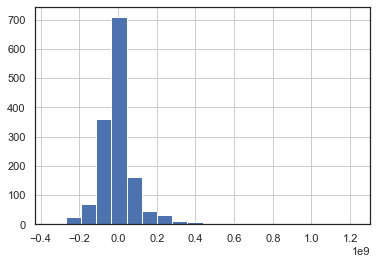

In [244]:
scores_revenue_lasso = get_error_metrics(y_test.revenue, 
                                         ypred_revenue_lasso, 
                                         "revenue_lasso")

del ypred_revenue_lasso

scores_revenue_lasso

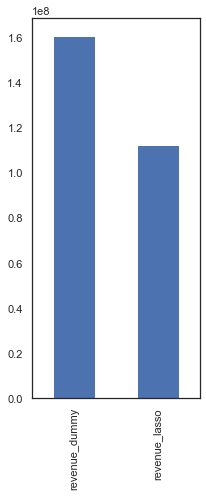

In [245]:
pd.DataFrame([scores_revenue_dummy,scores_revenue_lasso,]).RMSE.plot(kind='bar',figsize=(3,7))

People online say that if you have lots of zeroes in your dependent continuous variable, then maybe you should just make a classifier which buckets things into (hopefully) zero and non-zero samples, then train and run your regression model on the non-zero samples. Cool idea, but this is my secondary DV and I'd like to focus on IMdB critic scores for now, so I'll just move on.

**Plot Synopsis as Predictive Features**

In [246]:
X_plots_train_scaled = pd.read_pickle('../data/pickles/X_plots_train_scaled.pkl')
X_plots_test_scaled  = pd.read_pickle('../data/pickles/X_plots_test_scaled.pkl')

In [247]:
y_train = pd.read_pickle('../data/pickles/y_train.pkl')
y_test = pd.read_pickle('../data/pickles/y_test.pkl')

In [248]:
len(X_plots_train_scaled.index)

3362

We will do some PCA on the text features, given the large feature space with the plot text data.

In [249]:
lasso_critics_withplots = LassoCV(cv=5, random_state=42)

# Define a pipeline to search for the best PCA truncation
pca = PCA(random_state=42)
pipe = Pipeline(steps=[('pca', pca), 
                       ('lasso', lasso_critics_withplots)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': np.arange(100,550,50),
    'lasso__n_alphas': np.arange(50, 250, 50),
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1)

In [250]:
search.fit(X_plots_train_scaled, y_train.imdb_score)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.033):
{'lasso__n_alphas': 100, 'pca__n_components': 400}


In [251]:
ypred_plottext_searched = search.predict(X_plots_test_scaled)

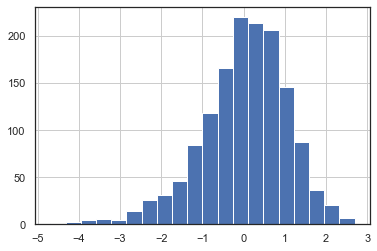

In [252]:
scores_critics_plottext_pca = get_error_metrics(y_test.imdb_score, 
                                            ypred_plottext_searched, 
                                            "imdb_pca_text")

In [253]:
scores_critics_plottext_pca

r^2       0.047033
RMSE      1.058117
Med_AE    0.665124
Name: imdb_pca_text, dtype: float64

A model trained on plot text features seems to do slightly better than the dummy regressor. Cool.

### Non-Parametric: Linear SVR

In [254]:
X_struct_train_poly_scaled = pd.read_pickle("../data/pickles/X_struct_train_poly_scaled.pkl")
X_struct_test_poly_scaled = pd.read_pickle("../data/pickles/X_struct_test_poly_scaled.pkl")

y_train = pd.read_pickle('../data/pickles/y_train.pkl')
y_test = pd.read_pickle('../data/pickles/y_test.pkl')

X_struct_train_poly_scaled.shape[0], X_struct_test_poly_scaled.shape[0]

(3362, 1441)

In [255]:
y_train.shape[0], y_test.shape[0]

(3362, 1441)

In [256]:
lin_svr = LinearSVR(random_state=42,
                    tol=1e-5,
                    max_iter=10**5)

lin_svr.fit(X_struct_train_poly_scaled, y_train.imdb_score)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=100000,
          random_state=42, tol=1e-05, verbose=0)

In [257]:
ypred_lin_svr = lin_svr.predict(X_struct_test_poly_scaled)

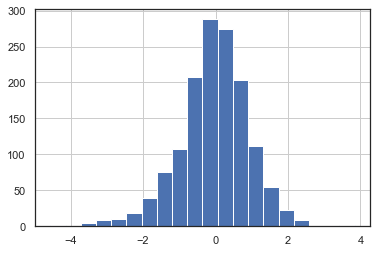

In [258]:
scores_critics_lin_svr = get_error_metrics(y_test.imdb_score, 
                                           ypred_lin_svr, 
                                          "imdb_lin_svr")

In [259]:
scores_critics_lin_svr

r^2       0.209904
RMSE      0.963462
Med_AE    0.564404
Name: imdb_lin_svr, dtype: float64

Not better than lasso.

In [260]:
pd.DataFrame([scores_critics_dummy,
              scores_critics_lasso,
              scores_critics_lin_svr])

,r^2,RMSE,Med_AE
critics_dummy,-0.029353,1.099707,0.700000
critics_lasso,0.267326,0.927790,0.555232
imdb_lin_svr,0.209904,0.963462,0.564404


### Non-Parametric (Tree-based): Random Forest

In [261]:
treegressor = RandomForestRegressor(random_state=42)

# Define a pipeline to search for the best params
pipe = Pipeline(steps=[('forest', treegressor)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'forest__max_depth': [1,2],
    'forest__n_estimators': [80,100,120]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1)

In [262]:
search.fit(X_struct_train_poly_scaled, y_train.imdb_score)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.189):
{'forest__max_depth': 2, 'forest__n_estimators': 120}


In [263]:
ypred_trees = search.predict(X_struct_test_poly_scaled)

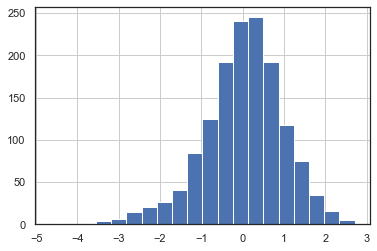

In [264]:
scores_forest = get_error_metrics(y_test.imdb_score, ypred_trees, "RandomForest")

In [265]:
pd.DataFrame([scores_critics_dummy,
              scores_critics_lasso,
              scores_critics_lin_svr,
              scores_forest])

,r^2,RMSE,Med_AE
critics_dummy,-0.029353,1.099707,0.700000
critics_lasso,0.267326,0.927790,0.555232
imdb_lin_svr,0.209904,0.963462,0.564404
RandomForest,0.187640,0.976942,0.589178


### Neural Net

In [266]:
def build_model(train_dataset):
    model = keras.Sequential([
        layers.Dense(64, kernel_regularizer=keras.regularizers.l1(0.01),
                     activation=tf.nn.relu, 
                     input_shape=[len(train_dataset.keys())]),

        keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l1(0.01),
                     activation=tf.nn.relu),

        keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [267]:
model = build_model(X_struct_train_poly_scaled)

# Print a summary of the model
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                24256     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 28,481
Trainable params: 28,481
Non-trainable params: 0
_________________________________________________________________
None


In [268]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(X_struct_train_poly_scaled, y_train.imdb_score,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0,
                    callbacks=[PrintDot()]
                   )

# Show last few epochs in history
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.tail())


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

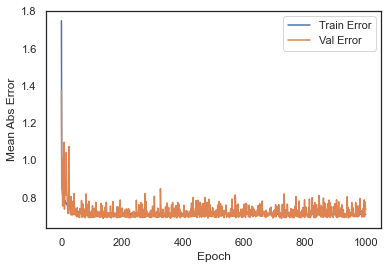

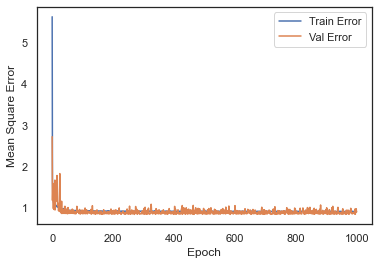

In [269]:
###############################################################################
############################### PLOT TRAINING #################################
###############################################################################

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, history.history['mae'],
           label='Train Error')
    plt.plot(history.epoch, history.history['val_mae'],
           label = 'Val Error')
    plt.legend()
#     plt.ylim([0,5])

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(history.epoch, history.history['mse'],
           label='Train Error')
    plt.plot(history.epoch, history.history['val_mse'],
           label = 'Val Error')
    plt.legend()
#     plt.ylim([0,20])
    plt.show()

plot_history(history)

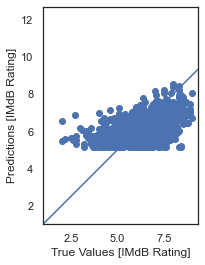

<function matplotlib.pyplot.show(*args, **kw)>

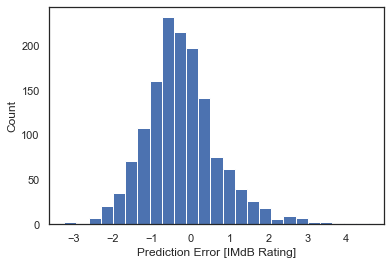

In [270]:
###############################################################################
############################# MAKE PREDICTIONS ################################
###############################################################################

# Make predictions from test-set

test_predictions = model.predict(X_struct_test_poly_scaled).flatten()

# Scatter plot plot
plt.scatter(y_test.imdb_score, test_predictions)
plt.xlabel('True Values [IMdB Rating]')
plt.ylabel('Predictions [IMdB Rating]')
plt.axis('equal')
plt.axis('square')
plt.xlim([1,plt.xlim()[1]])
plt.ylim([1,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

# Error plot
error = test_predictions - y_test.imdb_score
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [IMdB Rating]")
_ = plt.ylabel("Count")
plt.show

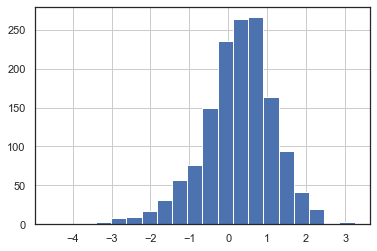

In [271]:
scores_dnn = get_error_metrics(y_test.imdb_score, test_predictions, "deep neural net")

In [272]:
losses = pd.DataFrame([scores_critics_dummy,
                      scores_critics_lasso,
                      scores_critics_lin_svr,
                      scores_forest,
                      scores_dnn]).sort_values('RMSE',ascending=False)

losses

,r^2,RMSE,Med_AE
critics_dummy,-0.029353,1.099707,0.700000
RandomForest,0.187640,0.976942,0.589178
deep neural net,0.199324,0.969891,0.621069
imdb_lin_svr,0.209904,0.963462,0.564404
critics_lasso,0.267326,0.927790,0.555232


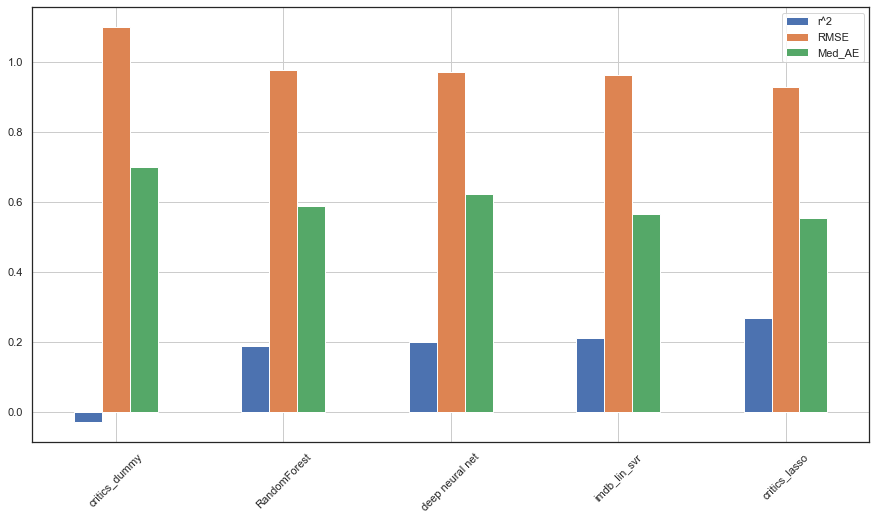

In [273]:
ax = losses.plot(kind='bar',figsize=(15,8),rot=45)
ax.grid()